# Testing segmentation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import skimage.io
import skimage.segmentation
import skimage.morphology
import skimage.measure
import skimage.exposure
import skimage.feature

import scipy.ndimage
import scipy.signal
import scipy.spatial

import glob
import itertools
%matplotlib inline

In [2]:
# Load in some data. 
SD2_glob = glob.glob('SD2_5ulmin_pre_5/Pos0/*.tif')
gfp = skimage.io.imread(SD2_glob[1])
phase = skimage.io.imread(SD2_glob[0])


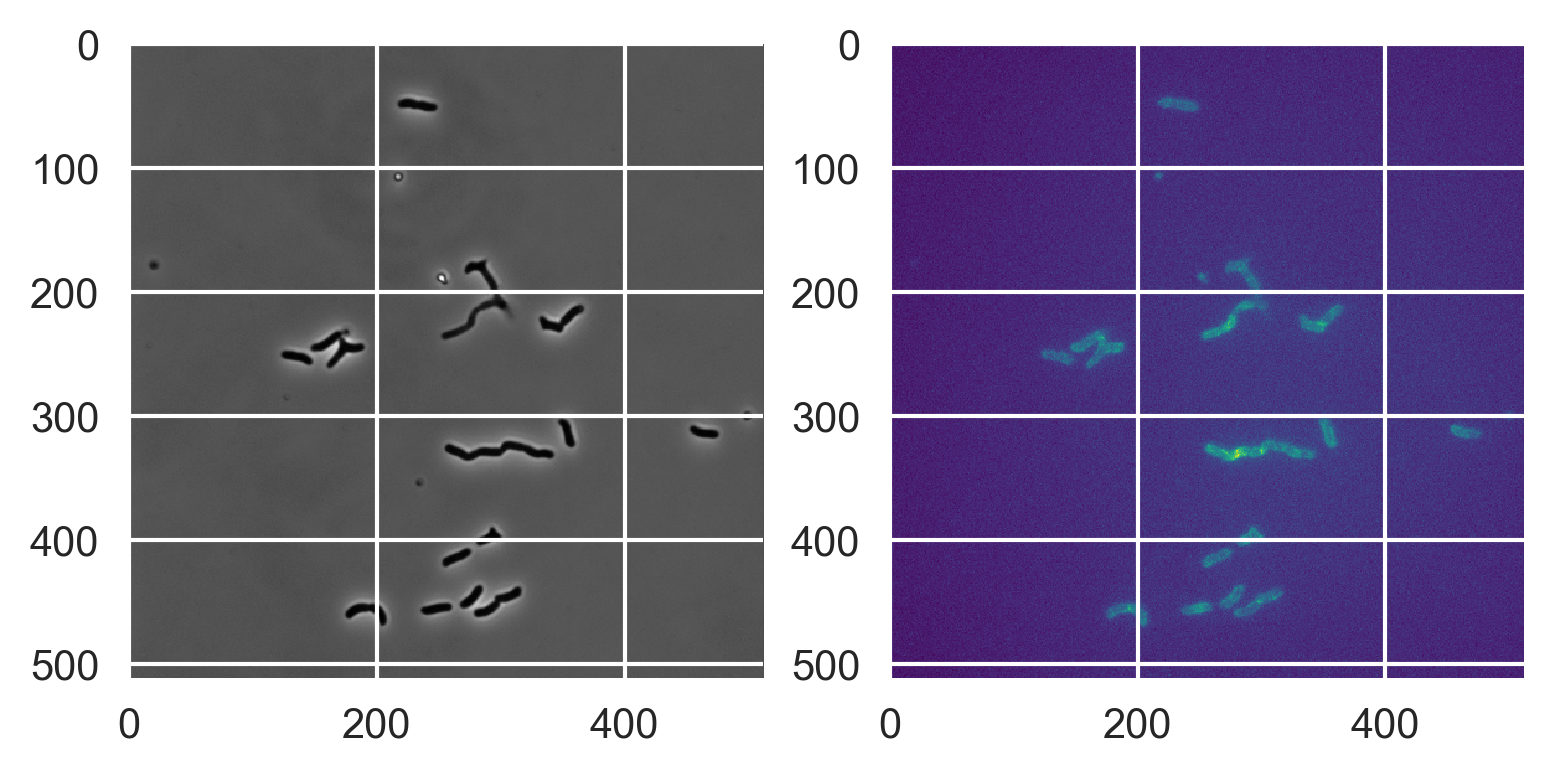

In [3]:
# Show the two images. 
fig, ax = plt.subplots(1,2)
ax[0].imshow(phase, cmap=plt.cm.Greys_r)
ax[1].imshow(gfp, cmap=plt.cm.viridis)

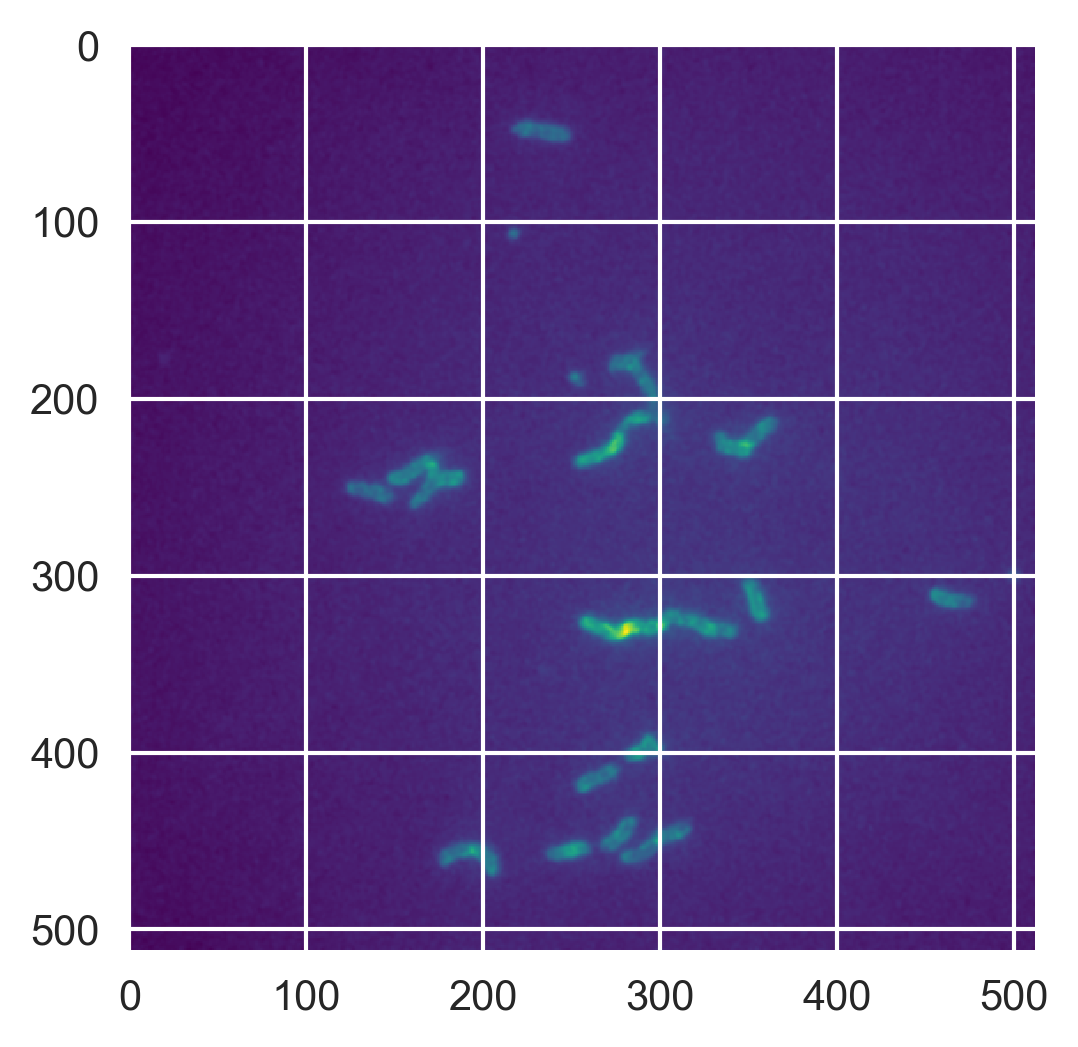

In [4]:
# Blur the gfp image. 
gfp_blur = skimage.filters.gaussian(gfp, sigma=1.0)
plt.imshow(gfp_blur, cmap=plt.cm.viridis)

In [5]:
import pboc

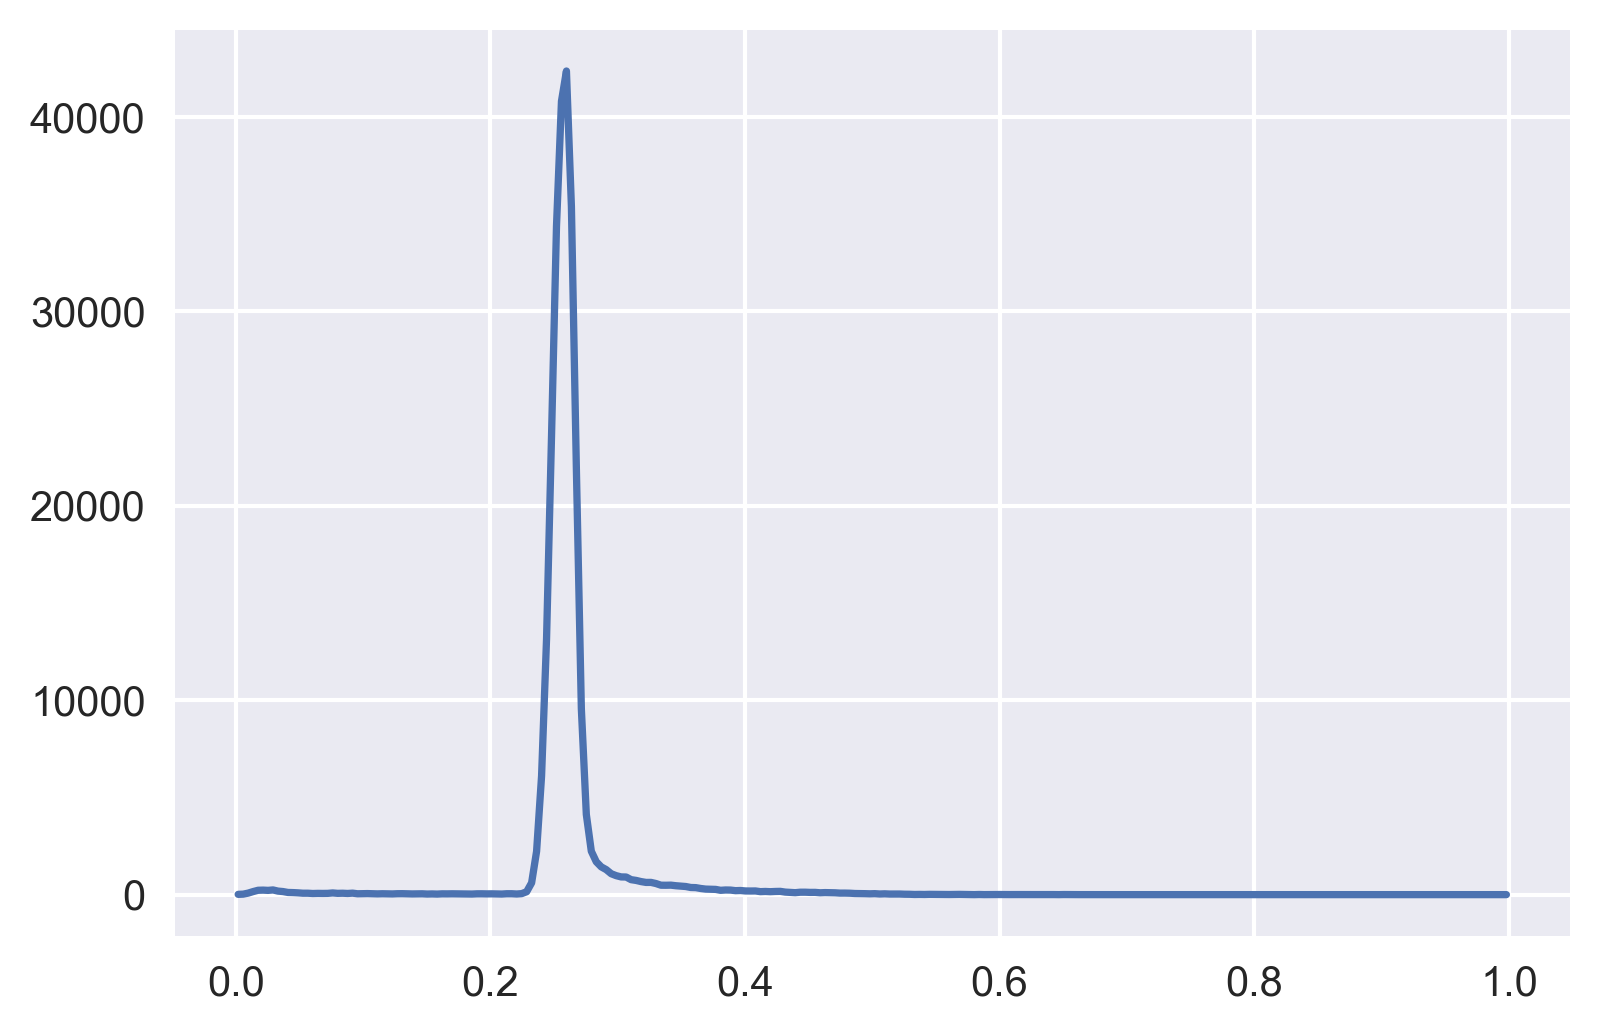

In [6]:
phase_float = pboc.im_to_float(phase)
hist, bins = skimage.exposure.histogram(phase_float)
plt.plot(bins, hist)

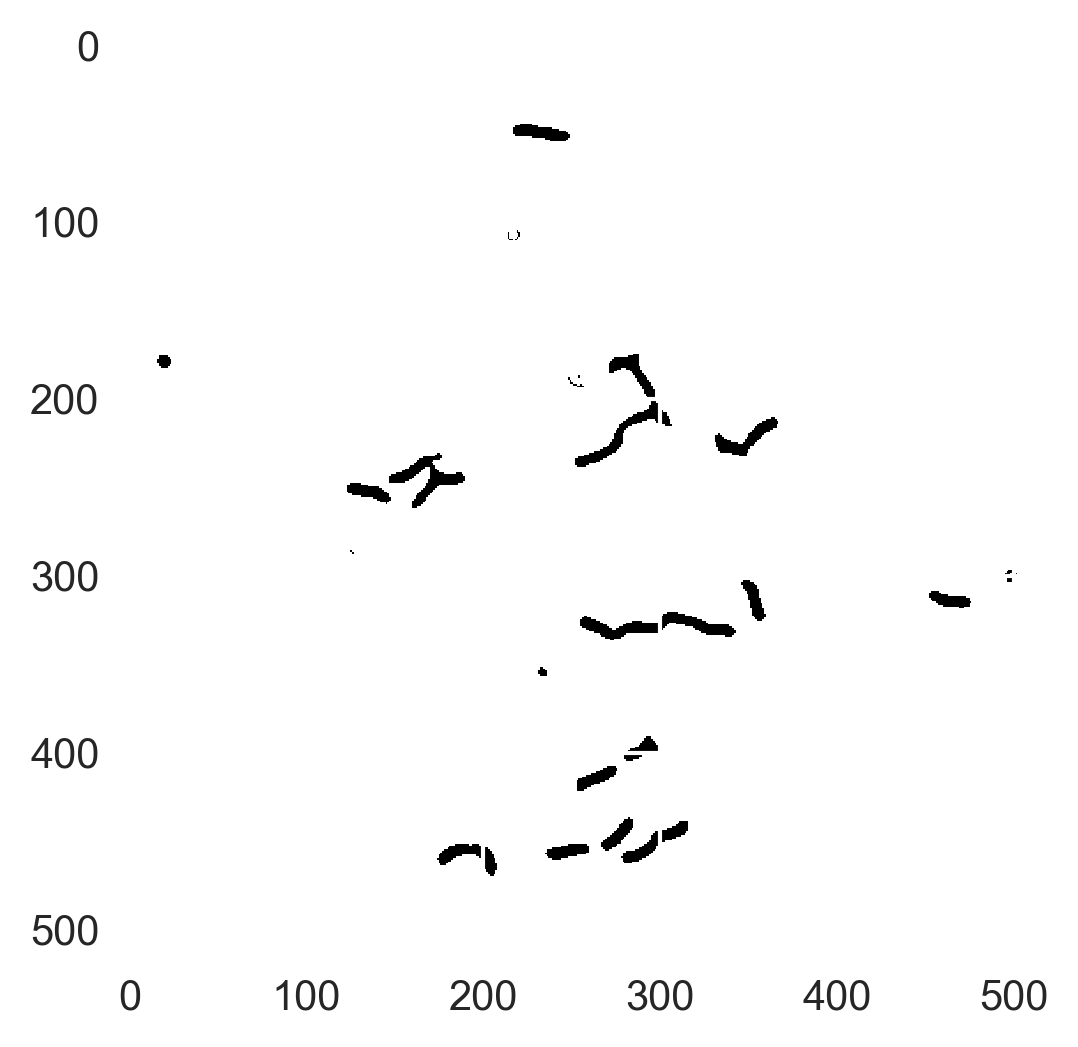

In [7]:
phase_seg = phase_float < 0.2
plt.imshow(phase_seg)

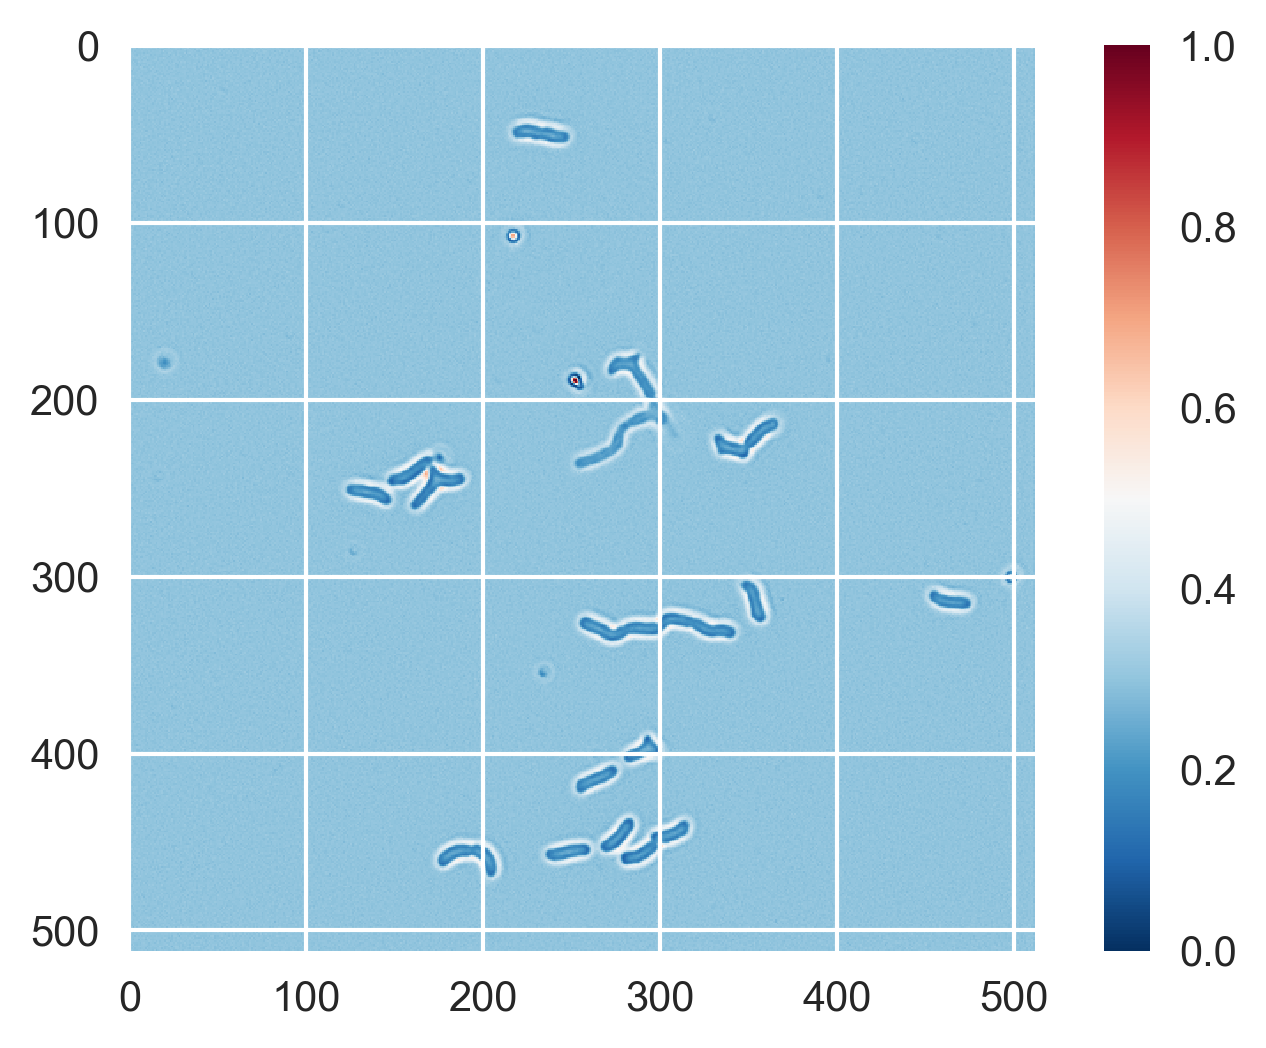

In [8]:
# Do a background subtraction on the phase image. 
phase_float = pboc.im_to_float(phase)
im_blur = skimage.filters.gaussian(phase_float, sigma=2)
im_sub =  phase_float - im_blur
im_sub_norm = pboc.im_to_float(im_sub)
plt.imshow(im_sub_norm, cmap=plt.cm.RdBu_r)
plt.colorbar()
log_seg = pboc.segmentation.log_segmentation(im_sub)

In [9]:
import scipy.ndimage

In [10]:
im_log = scipy.ndimage.filters.gaussian_laplace(im_sub, sigma=2)

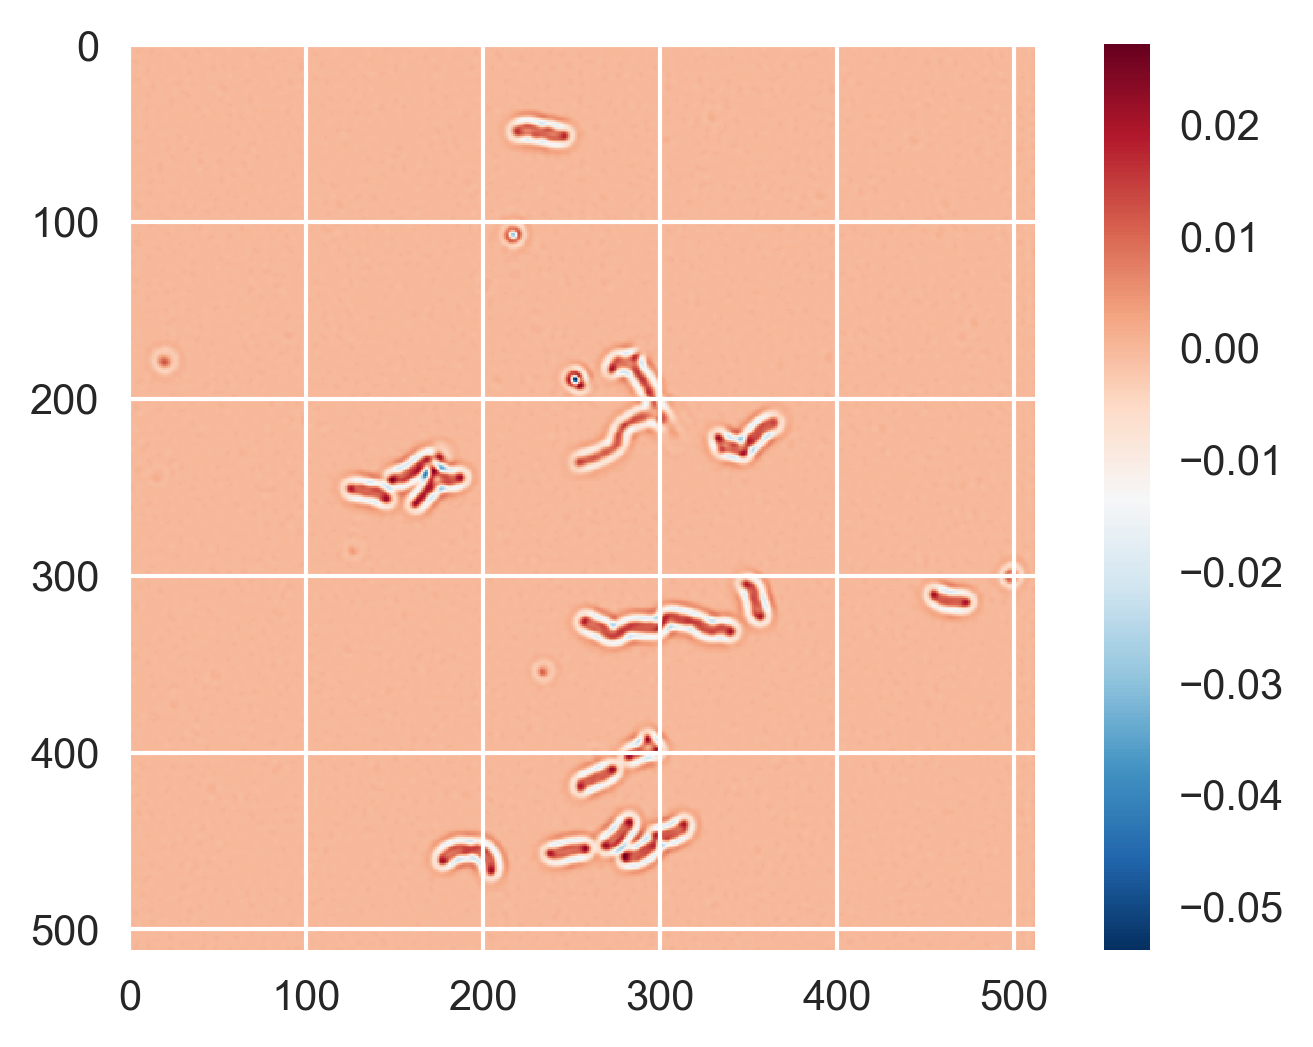

In [11]:
plt.imshow(im_log, cmap=plt.cm.RdBu_r)
plt.colorbar()

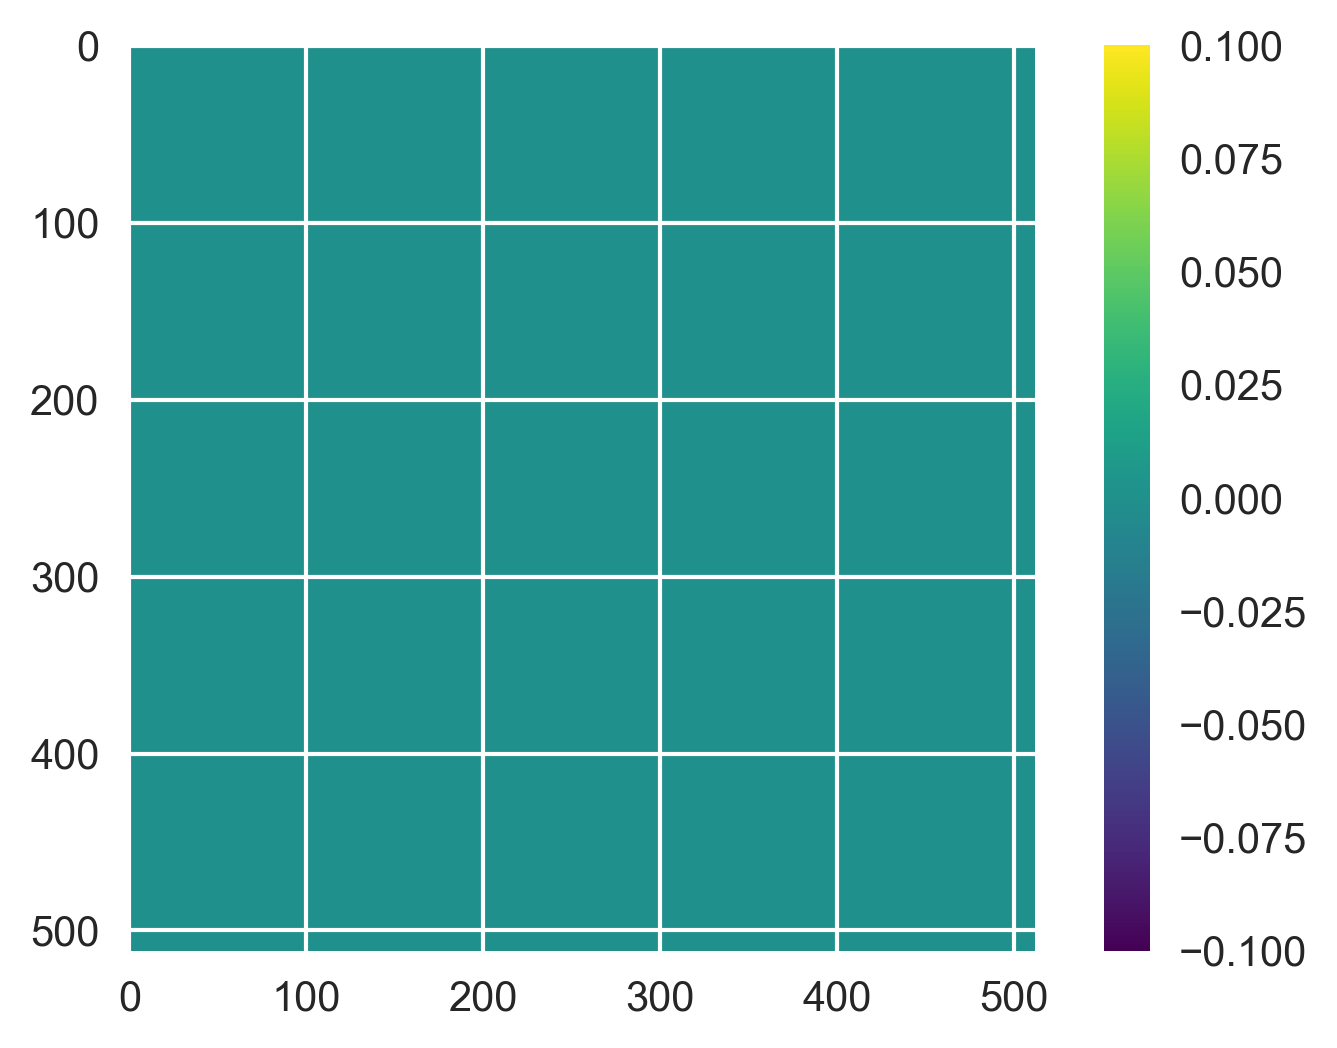

In [12]:
# Perform a minimum filter. 
selem = skimage.morphology.disk(1)
max_filt = scipy.ndimage.filters.maximum_filter(im_log, footprint=selem)
plt.imshow(max_filt > 0.05, cmap=plt.cm.viridis)
plt.colorbar()

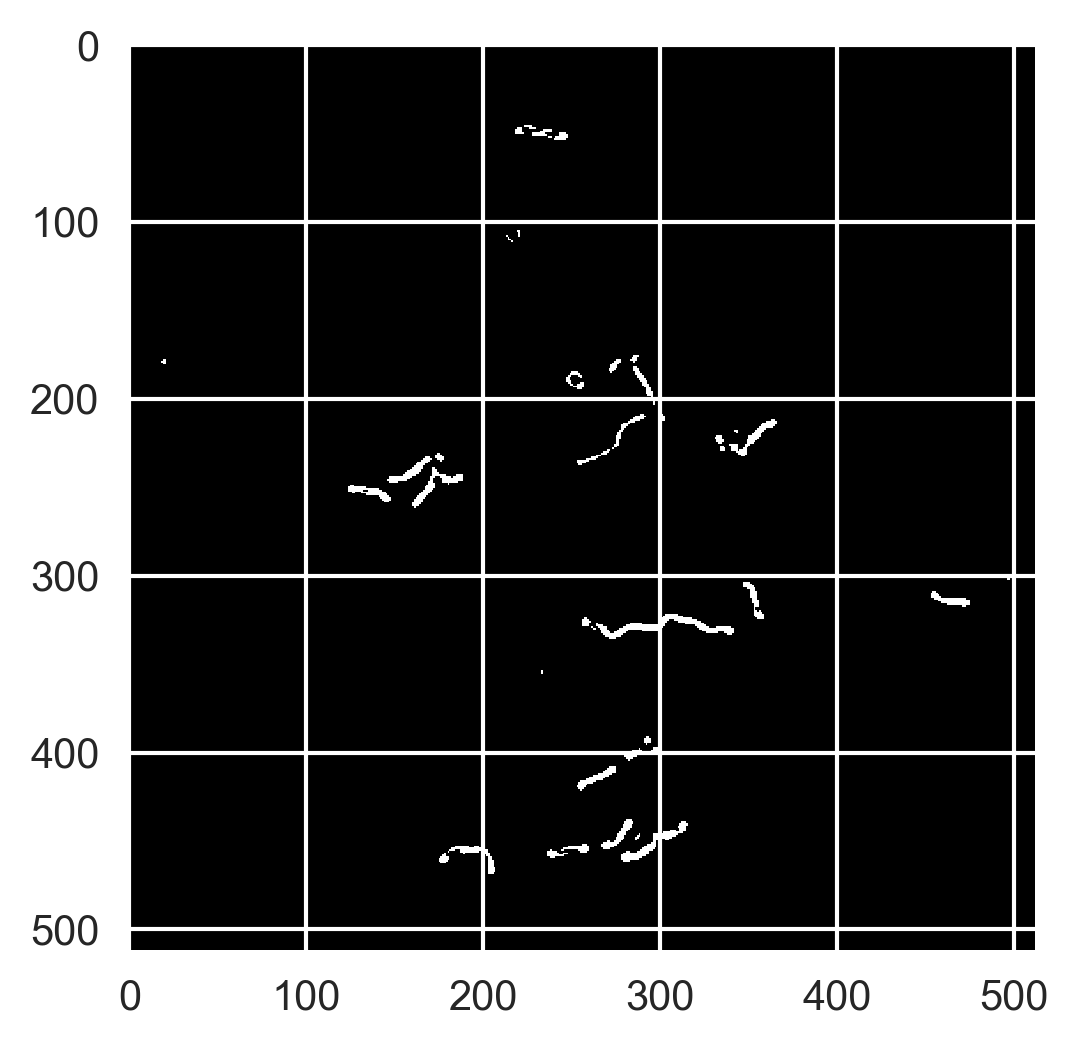

In [13]:
plt.imshow(im_log < 0.01)

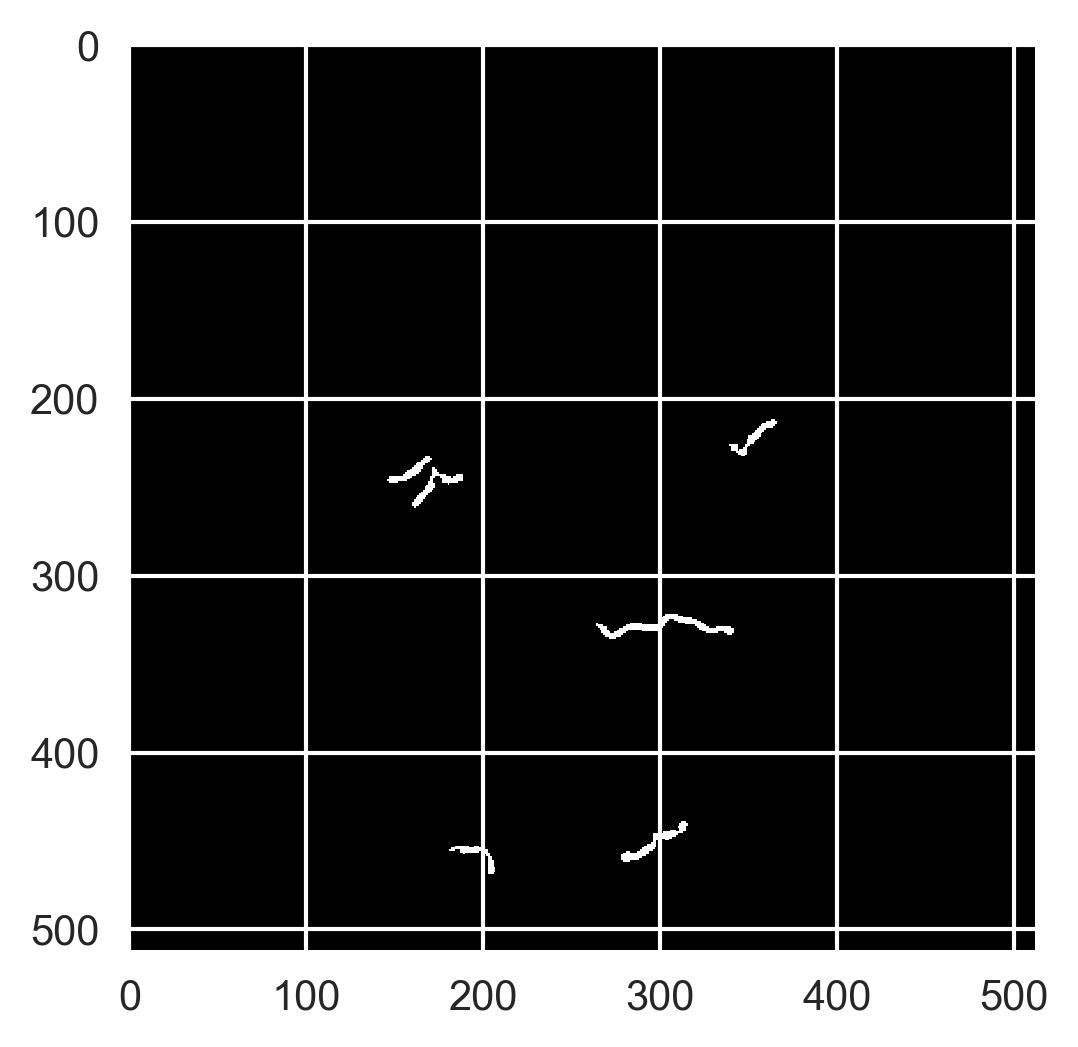

In [14]:
# Threshold and fill. 
im_thresh = im_log > 0.01
# im_close = scipy.ndimage.binary_closing(im_thresh)
im_fill = scipy.ndimage.binary_fill_holes(im_thresh)
im_large = skimage.morphology.remove_small_objects(im_fill, min_size=100)
plt.imshow(im_large, cmap = plt.cm.Greys_r)

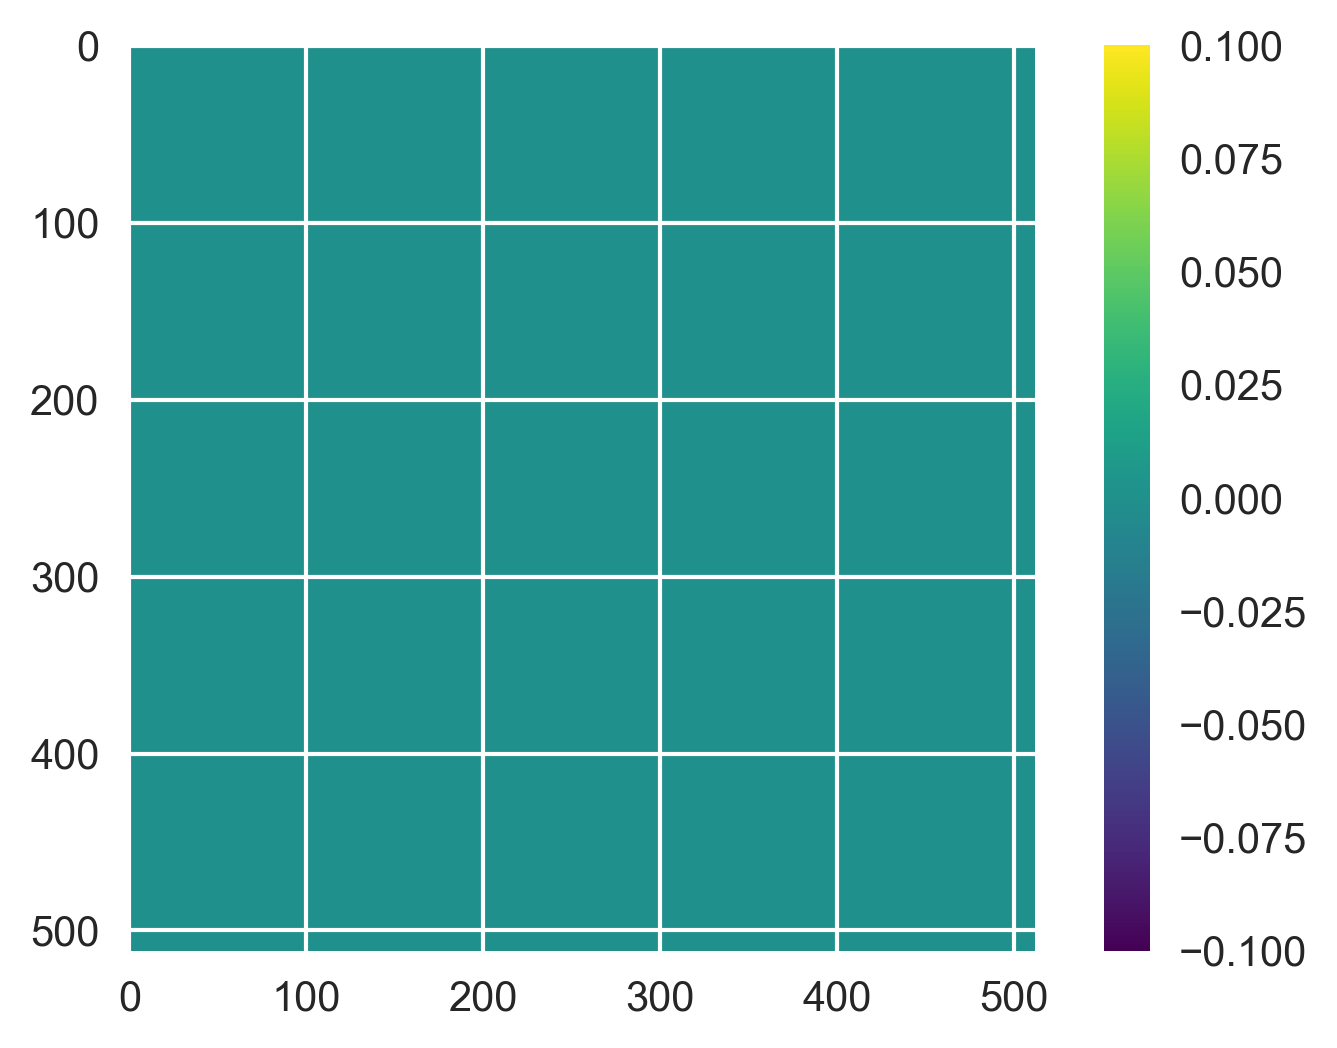

In [15]:
# Compute the distance transform. 
im_dist = scipy.ndimage.distance_transform_bf(im_large)
plt.imshow(im_dist > 3.5, cmap=plt.cm.viridis)
plt.colorbar()

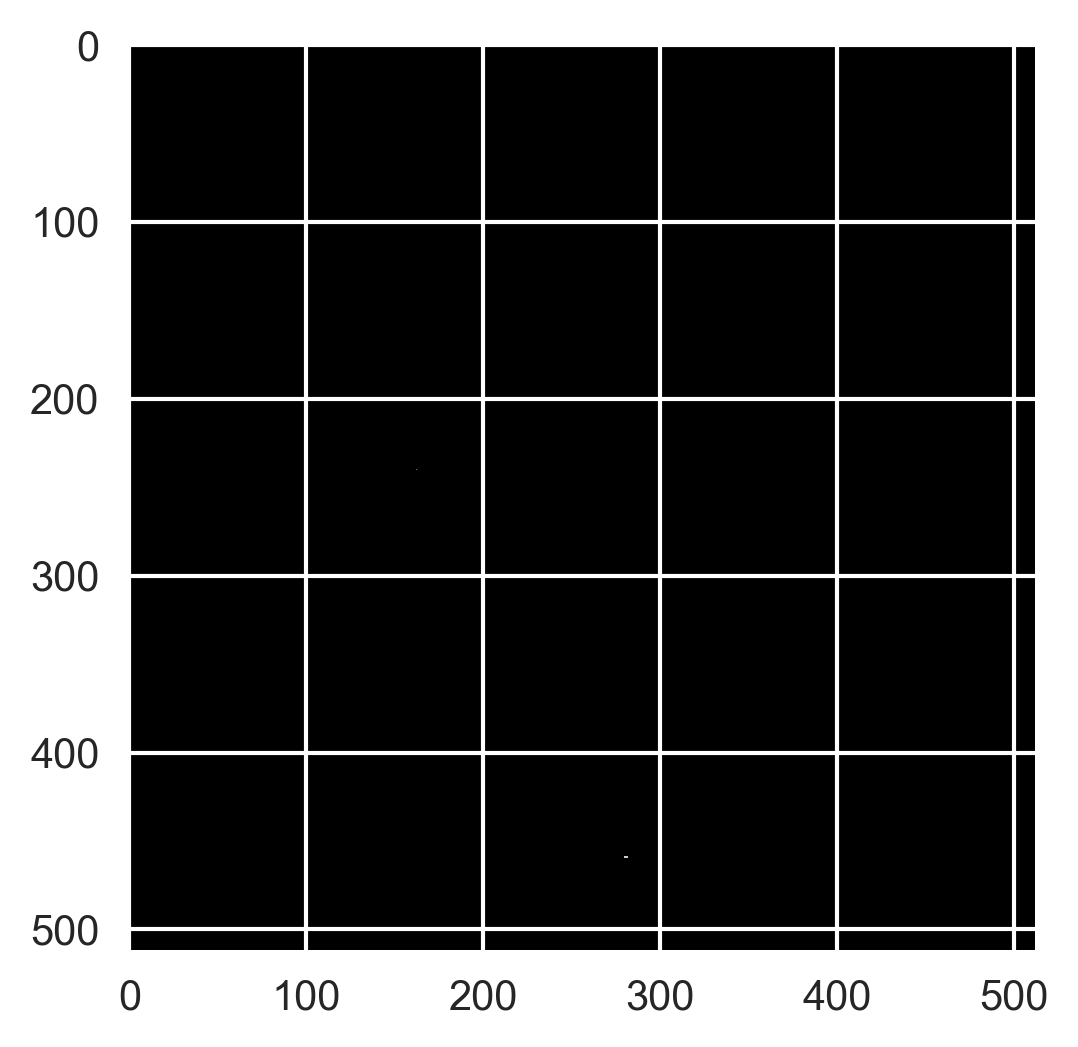

In [16]:
# Find the peaks of the distance transform. 
peaks = skimage.feature.peak_local_max(im_dist, threshold_rel=0.8, min_distance=25, indices=False)
lab = skimage.measure.label(peaks)
plt.imshow(lab, cmap=plt.cm.spectral)

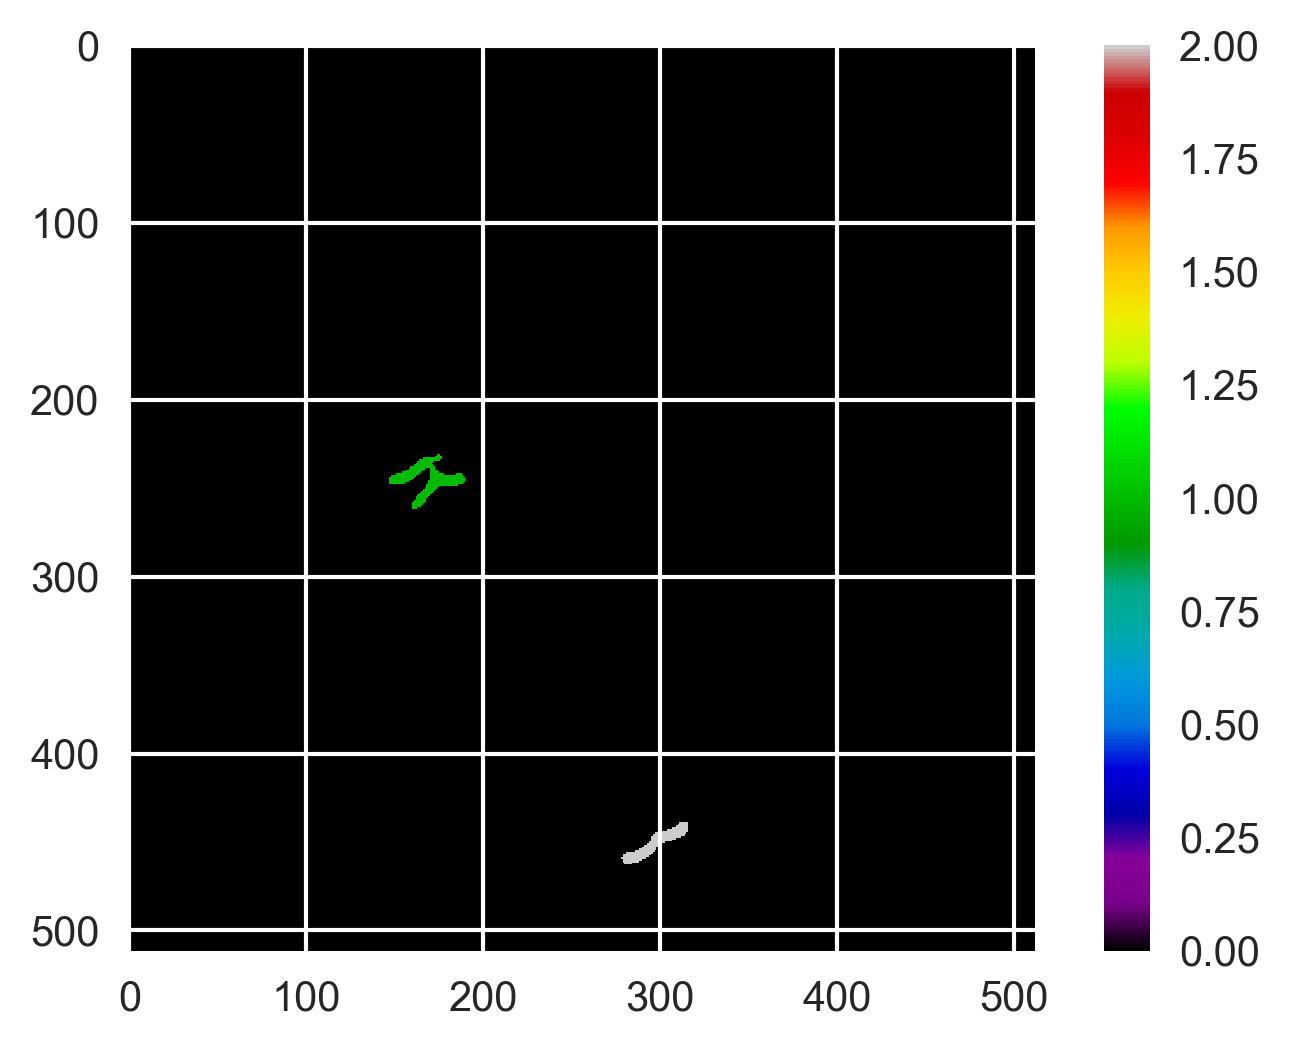

In [17]:
wshed = skimage.morphology.watershed(-im_dist, markers=lab, mask=phase_seg)
plt.imshow(wshed, cmap=plt.cm.spectral)
plt.colorbar()

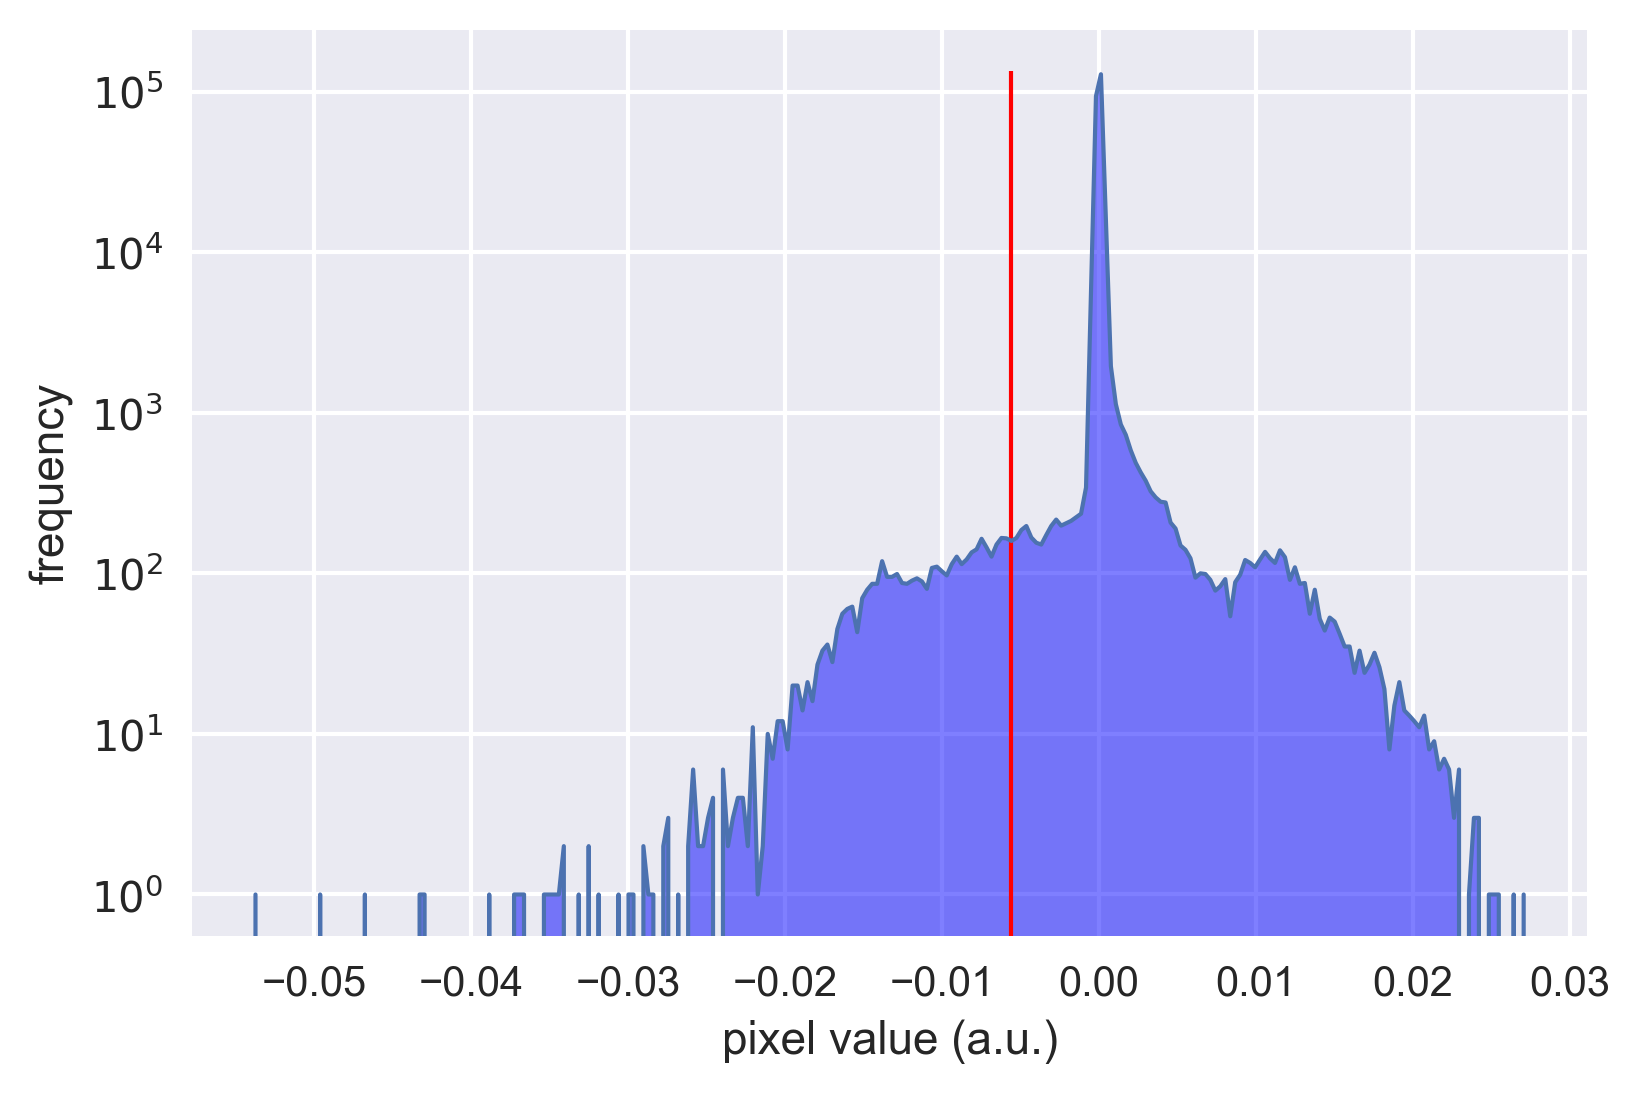

In [18]:
# Determine the threshold. 
thresh_val = skimage.filters.threshold_otsu(im_log)

# Look at the image histogram. 
hist, bins = skimage.exposure.histogram(im_log)
plt.plot(bins, hist, lw=1)
plt.fill_between(bins, hist, color='b', alpha=0.5)
ax = plt.gca()
plt.vlines(thresh_val, ax.get_ylim()[0], ax.get_ylim()[1], lw=1, color='r')
plt.xlabel('pixel value (a.u.)')
plt.ylabel('frequency')
plt.yscale('log')


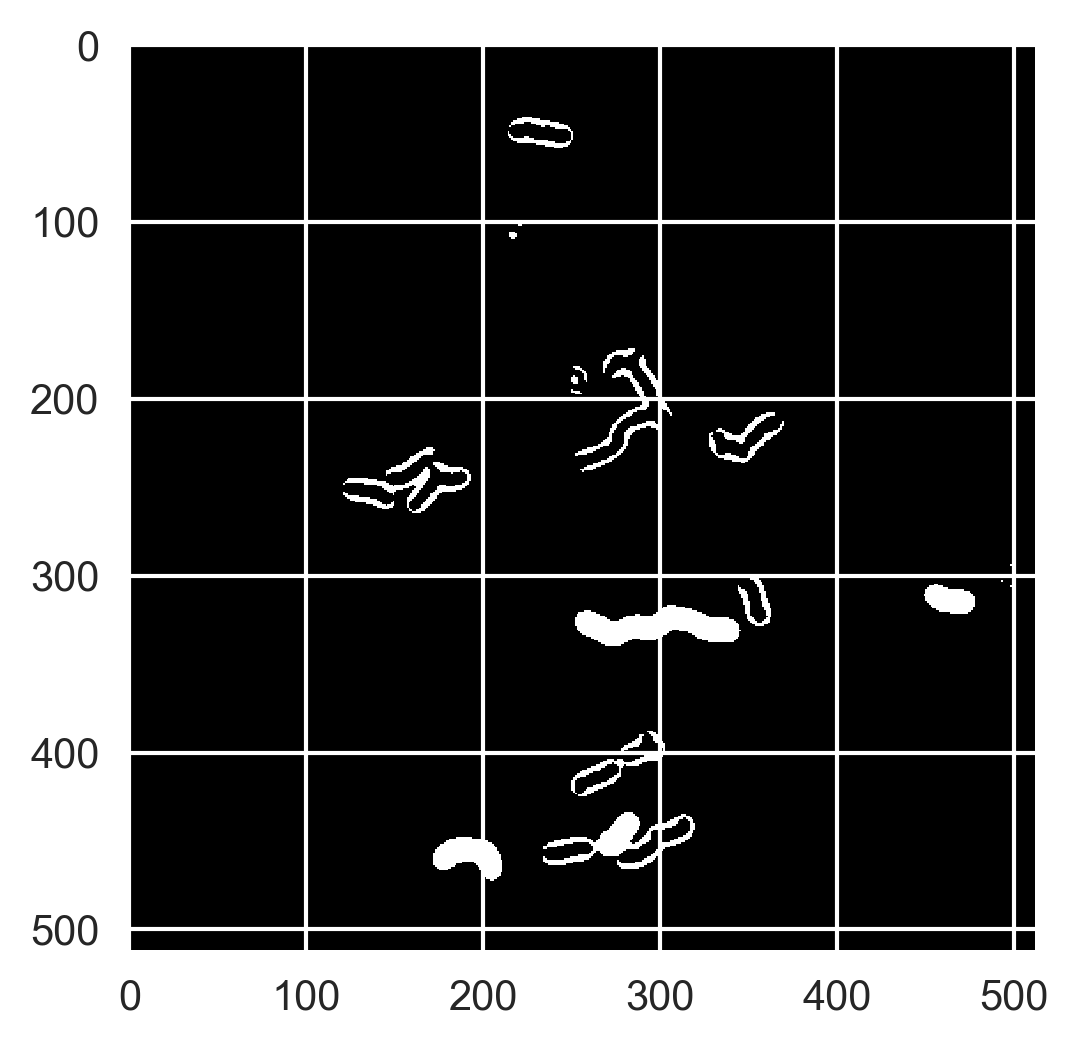

In [19]:
# Apply the threshold and close. 
im_thresh = im_log < thresh_val
im_close = skimage.morphology.binary_closing(im_thresh)
im_fill = scipy.ndimage.binary_fill_holes(im_close)
plt.imshow(im_fill, cmap = plt.cm.Greys_r)

##  Active contouring

In [20]:
s = np.linspace(0, 2 * np.pi, 4000)
x = 256 + 256 * np.cos(s)
y = 256 + 256 * np.sin(s)
init = np.array([x, y]).T

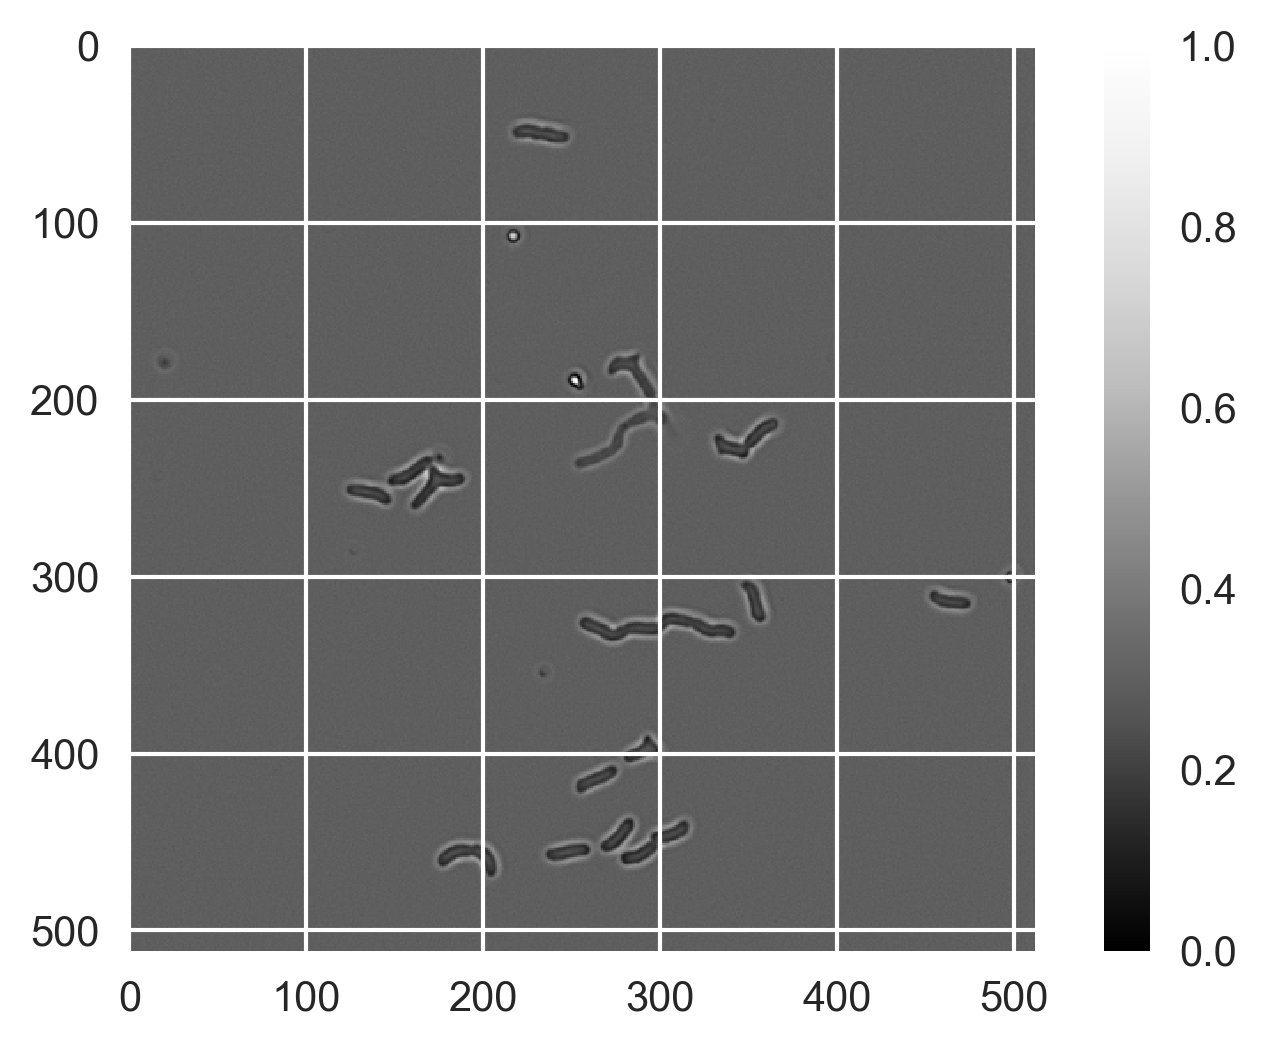

In [24]:
plt.imshow(im_sub_norm, cmap=plt.cm.Greys_r)
plt.colorbar()

KeyboardInterrupt: 

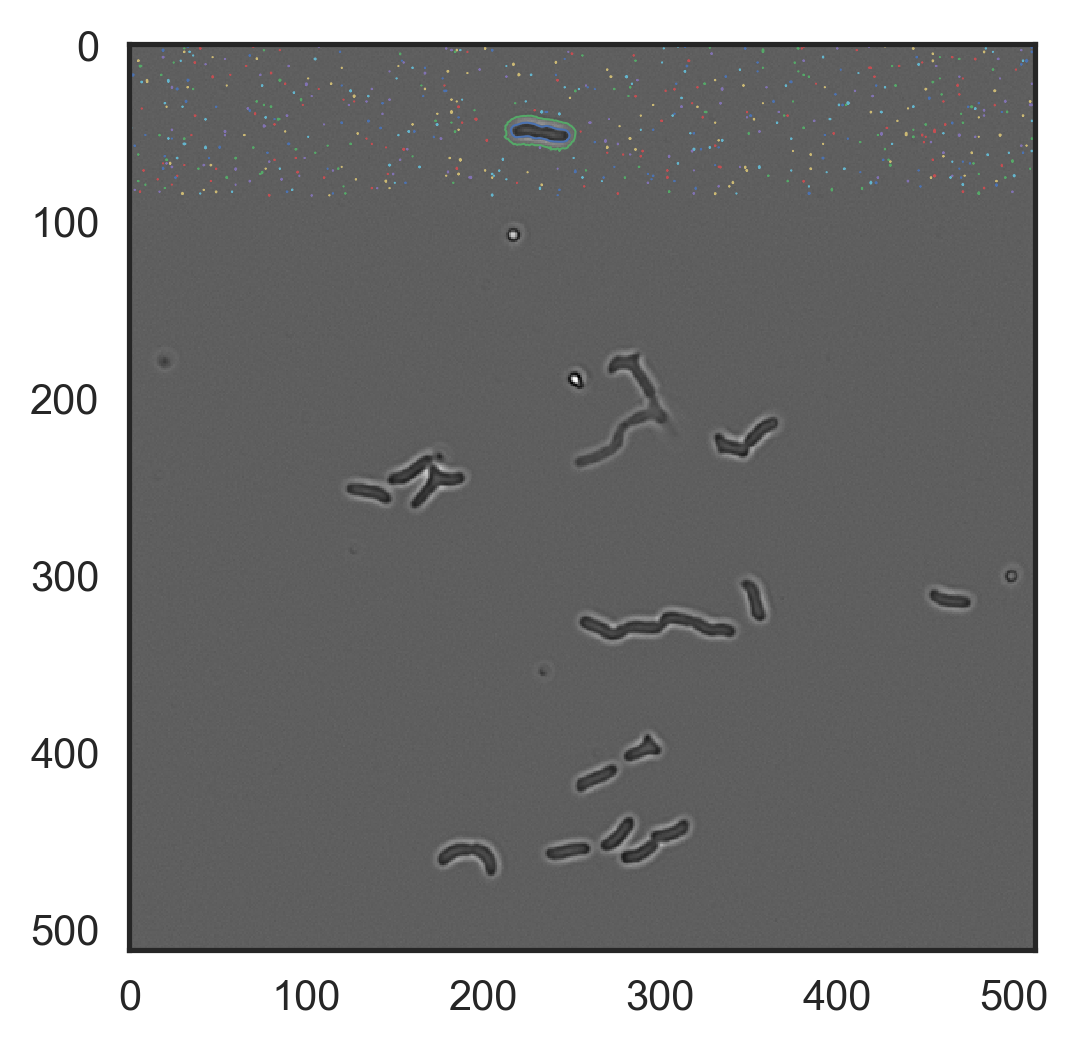

In [25]:
conts = skimage.measure.find_contours(im_sub, 0.01)
conts3 = skimage.measure.find_contours(im_blur, 0.0)
conts2 = skimage.measure.find_contours(im_blur, 0.0)
contz = [conts, conts2, conts3]
new_im = np.zeros_like(phase_float)

with sns.axes_style('white'):
    plt.imshow(im_sub, cmap=plt.cm.Greys_r)
    for j, z in enumerate(contz):
        for i, cont in enumerate(z):
            locs_x = cont[:, 1].astype(int)
            locs_y = cont[:, 0].astype(int) 
            z = np.zeros_like(phase_float)
            z[locs_x, locs_y] = 1.0
            fill = scipy.ndimage.binary_fill_holes(z)
            new_im = new_im + fill
            plt.plot(cont[:, 1], cont[:, 0], lw=0.5)

# skel = skimage.morphology.skeletonize(new_im)
# fill = scipy.ndimage.binary_fill_holes(skel)
# erode = skimage.morphology.binary_erosion(fill)
# large = skimage.morphology.remove_small_objects(large)
plt.xlim([150,350])
plt.ylim([300,512])


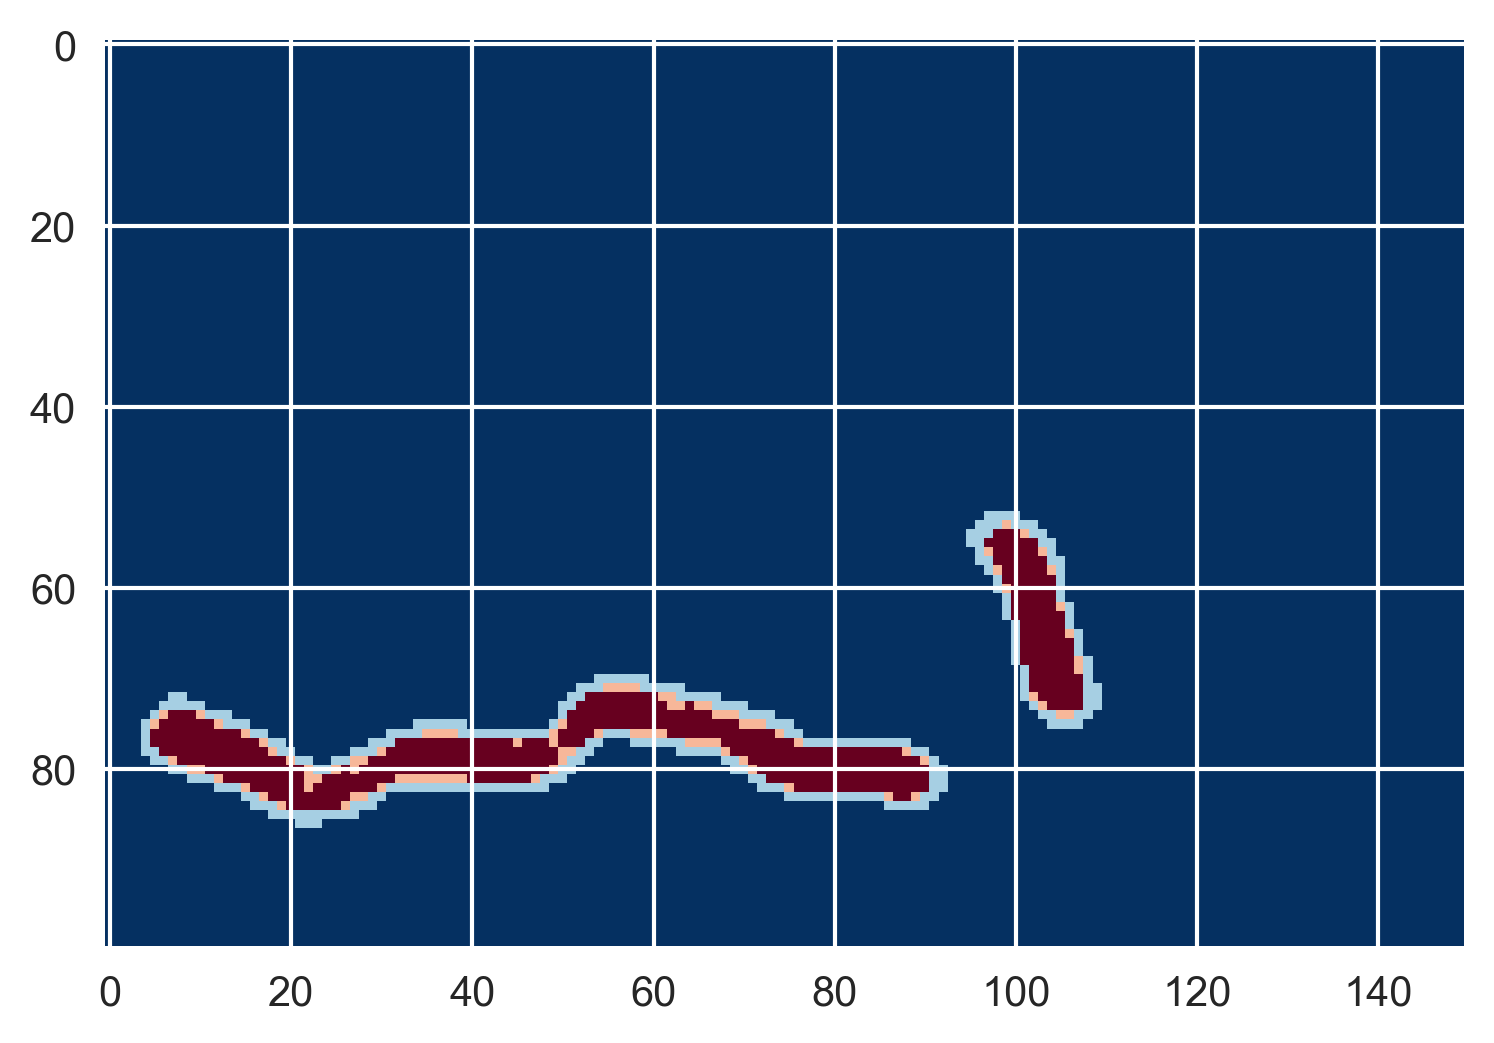

In [34]:
plt.imshow(new_im.T[250:350, 250:400], cmap=plt.cm.RdBu_r)

In [36]:
dist = scipy.ndimage.distance_transform_cdt(dil > 0)
selem = skimage.morphology.square(6)
peaks = skimage.feature.peak_local_max(dist, indices=False,min_distance=15)
peak_lab = skimage.measure.label(peaks)
plt.imshow(peak_lab, cmap=plt.cm.spectral)

NameError: name 'dil' is not defined

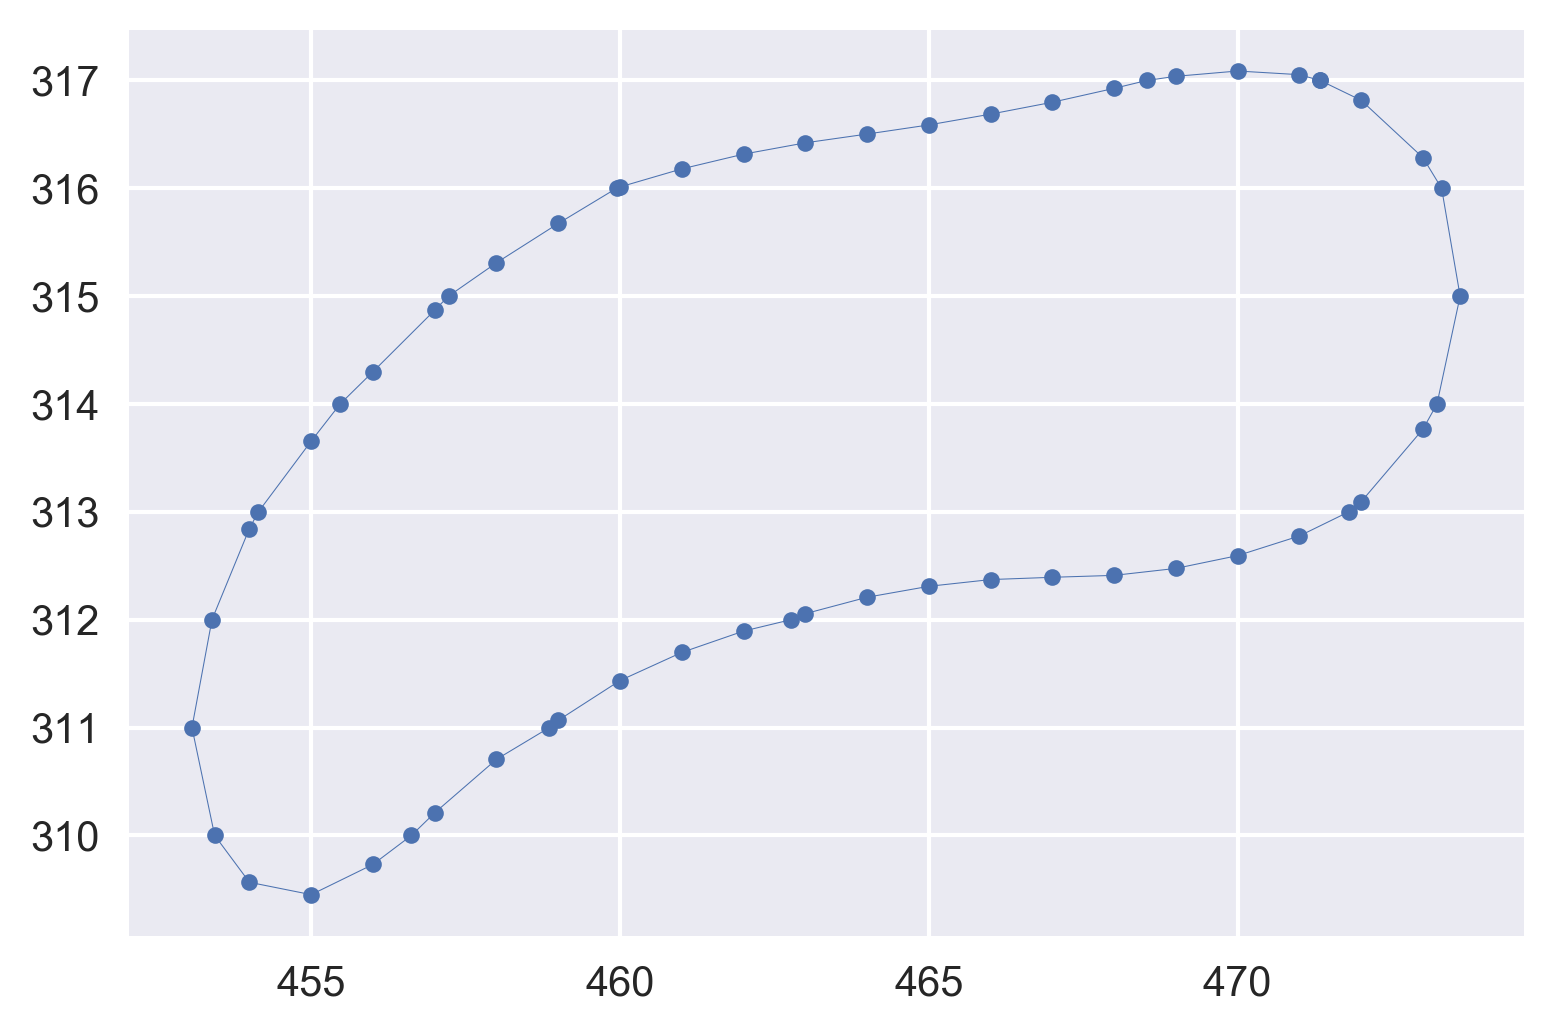

In [37]:
i = 12
plt.plot(conts[i][:,1], conts[i][:,0], '-o', lw=0.25, ms=4)



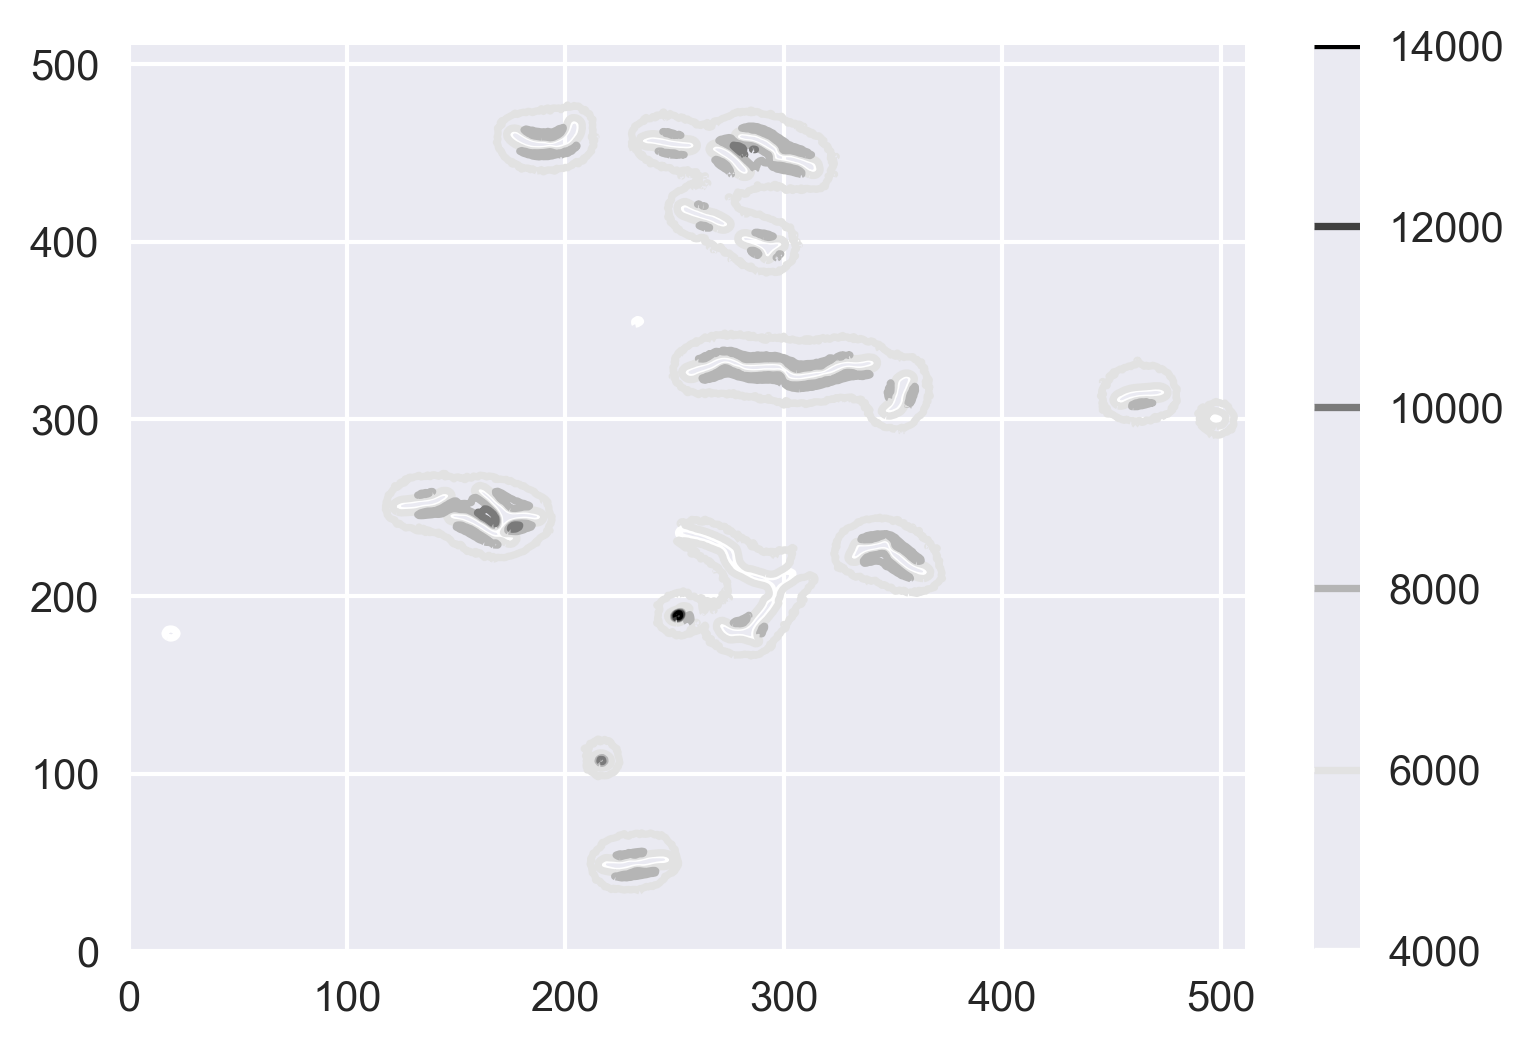

In [38]:
plt.contour(phase)
plt.colorbar()

In [39]:
wshed = skimage.morphology.watershed(phase, peak_lab)

NameError: name 'peak_lab' is not defined

In [40]:
plt.imshow(wshed * dil, cmap=plt.cm.spectral_r)
plt.colorbar()

NameError: name 'dil' is not defined

In [41]:
wshed = skimage.morphology.watershed

In [42]:
plt.imshow(dist, cmap=plt.cm.viridis)
plt.colorbar()

NameError: name 'dist' is not defined

# Trying this approach on other phase images. 

In [209]:
phase_glob = glob.glob('Pos1/*Brightfield*.tif')
phase_ims = skimage.io.ImageCollection(phase_glob)

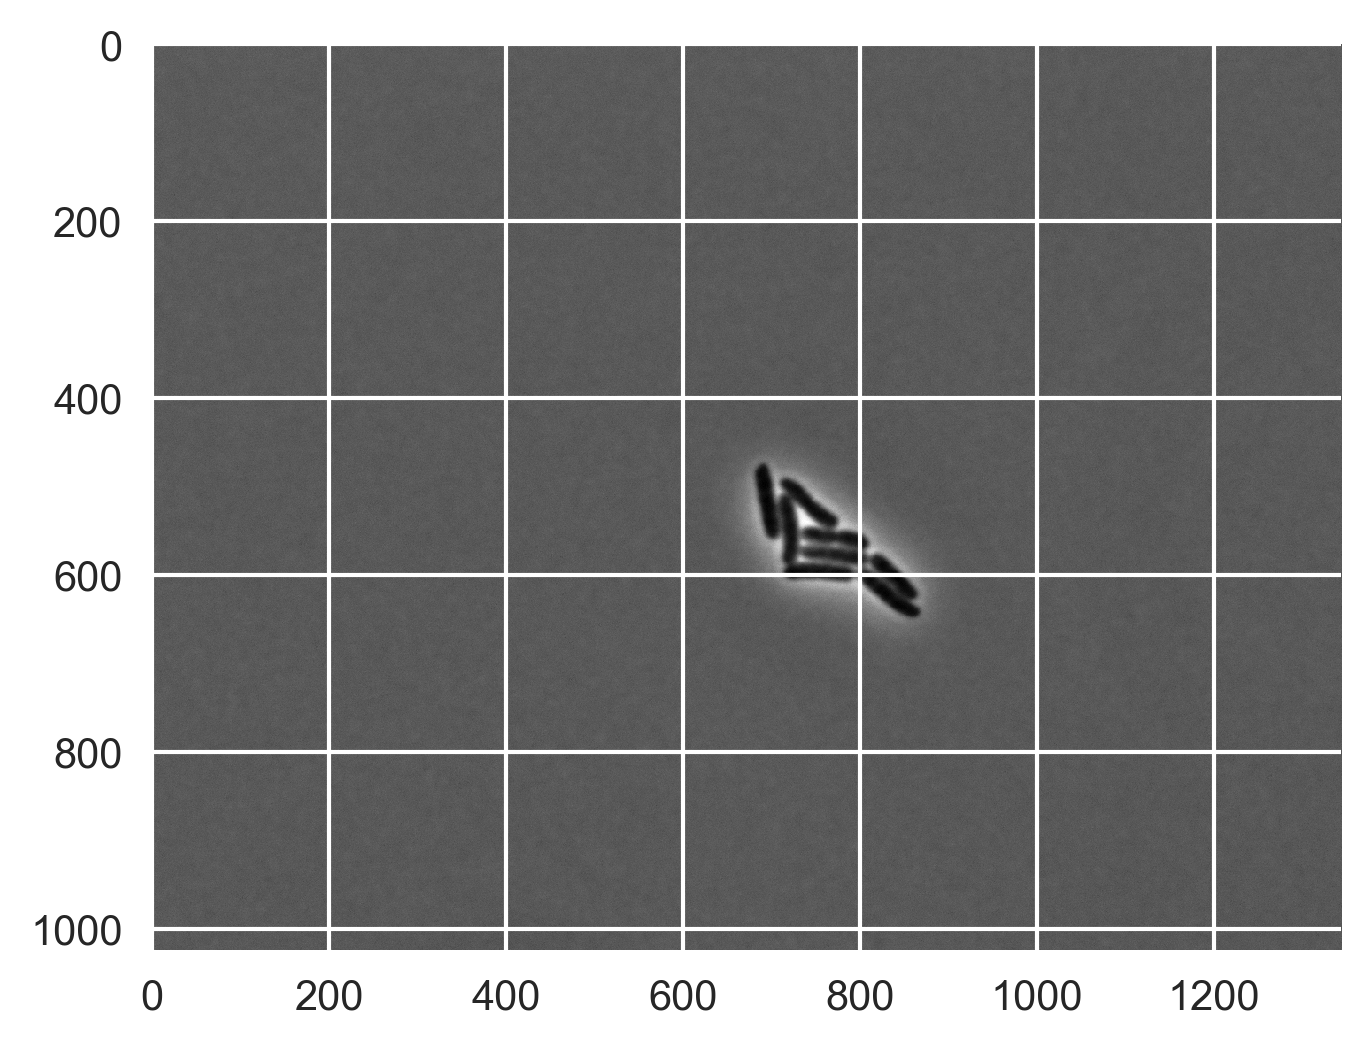

In [210]:
growth_phase = phase_ims[3]
growth_float = pboc.im_to_float(growth_phase)
growth_blur = skimage.filters.gaussian(growth_phase, sigma=4)
growth_sub = growth_float - growth_blur
plt.imshow(growth_sub, cmap=plt.cm.Greys_r)

/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


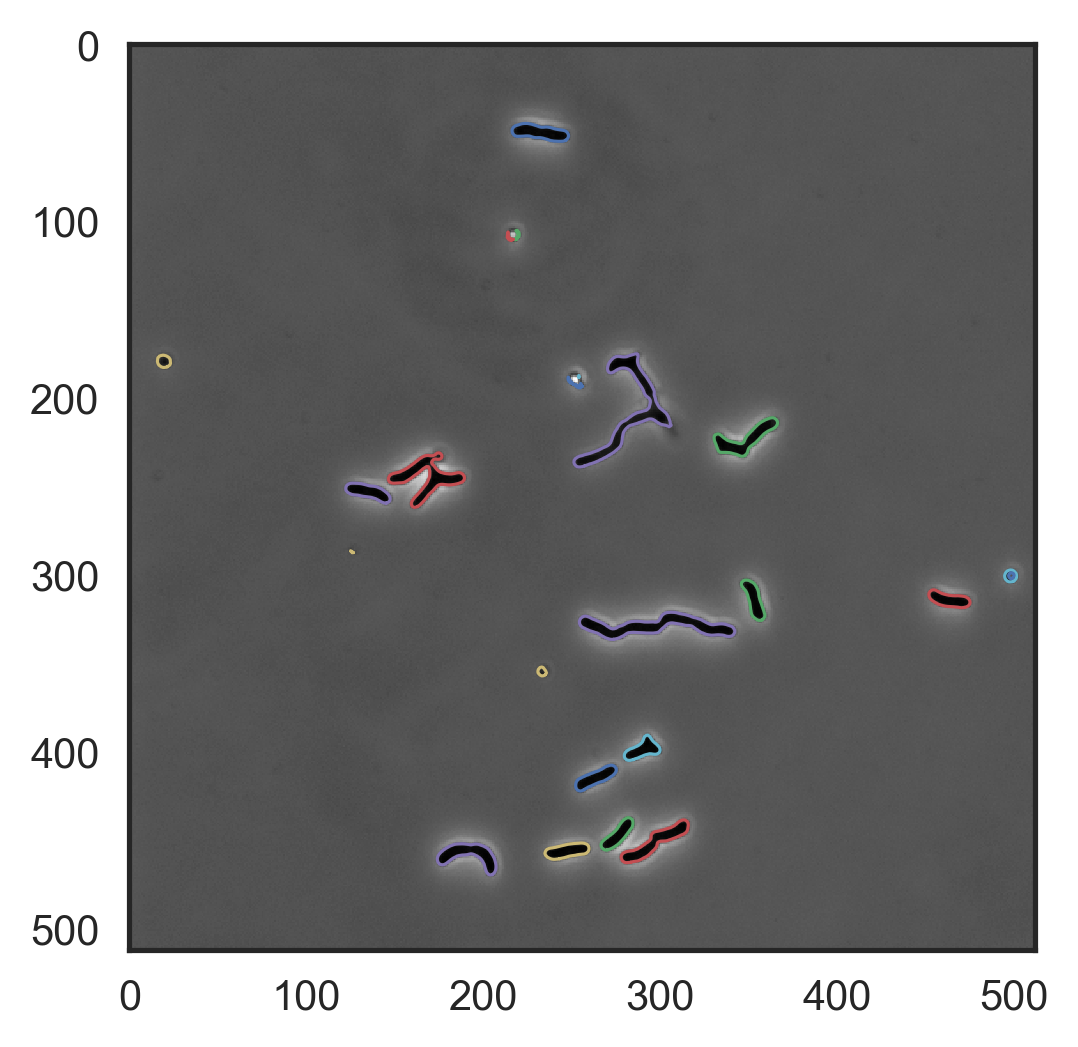

In [212]:
growth_cont = skimage.measure.find_contours(phase_float, 0.2)
app_im = np.zeros_like(growth_float)
with sns.axes_style('white'):
    plt.figure()
    plt.imshow(phase_float, cmap=plt.cm.Greys_r)
    for i, cont in enumerate(growth_cont):      
        plt.plot(cont[:, 1], cont[:, 0], lw=0.75)
        locs_x = cont[:, 0].astype(int)
        locs_y = cont[:, 1].astype(int)
        single_obj = np.zeros_like(growth_phase)
        single_obj[locs_x, locs_y] = 1.0
        filled = scipy.ndimage.binary_fill_holes(single_obj)
        large = skimage.morphology.remove_small_objects(filled)
        opened = scipy.ndimage.binary_opening(large)
        opened =  opened * i
        app_im += opened



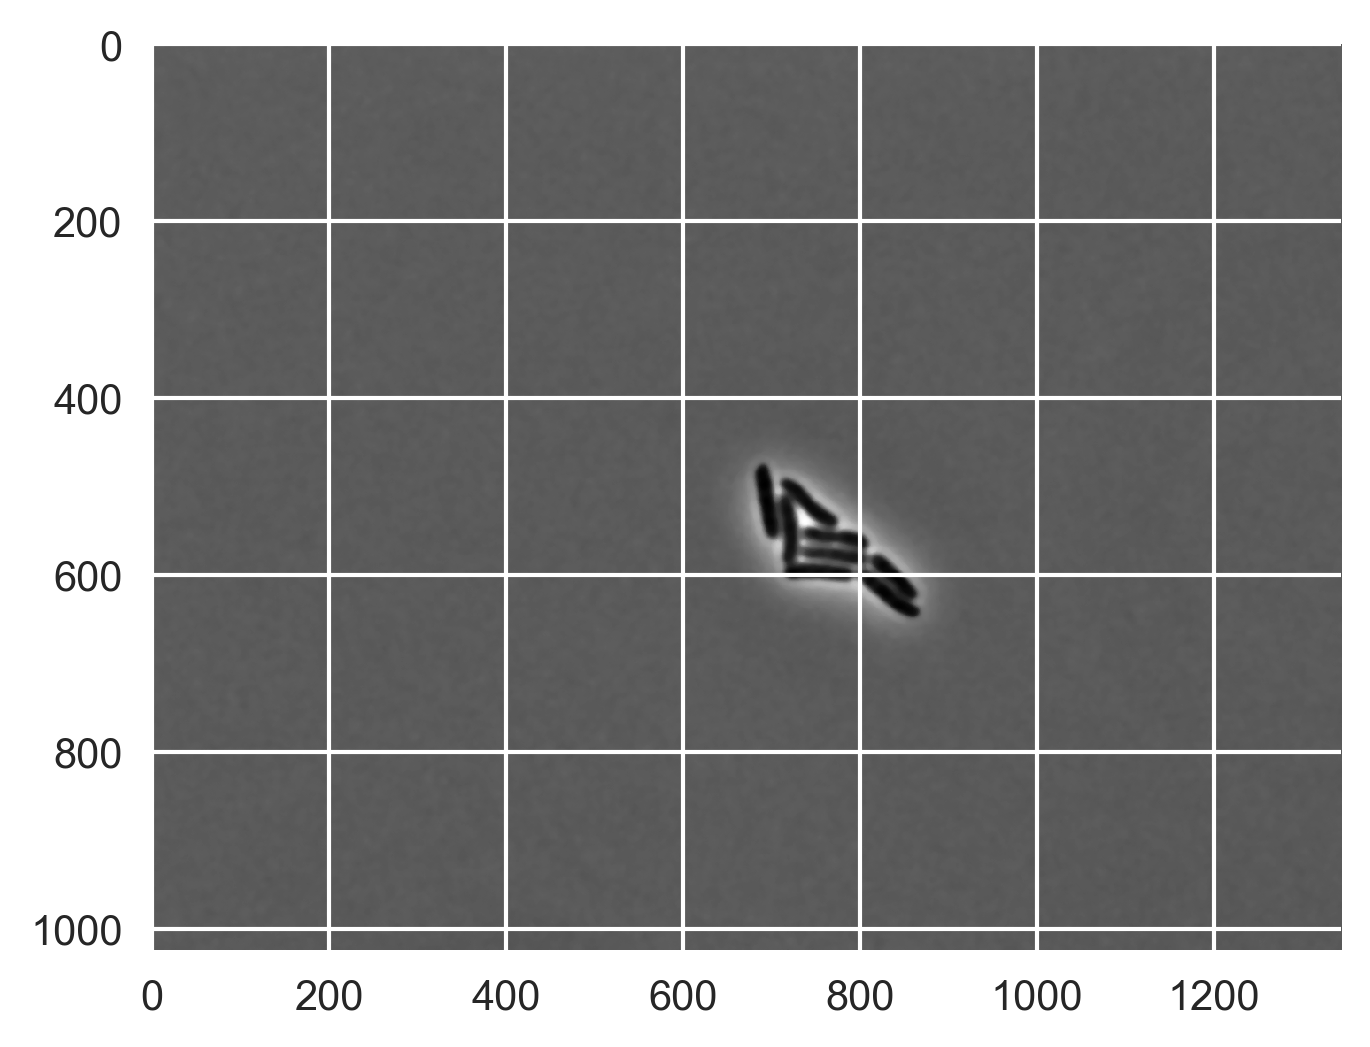

In [29]:
selem = skimage.morphology.disk(4)
min_filt = scipy.ndimage.filters.median_filter(growth_sub, footprint=selem)
plt.imshow(min_filt,cmap=plt.cm.Greys_r)

In [30]:
len(min_conts)

NameError: name 'min_conts' is not defined

In [1]:
min_filt_float = pboc.im_to_float(min_filt)
min_conts = skimage.measure.find_contours(phase_float, 0.20)
                                          
cont_levels = [0.05, 0.1, 0.13, 0.15, 0.17, 0.2]
min_size= 25
conts = []
for lev in cont_levels:
    conts.append(skimage.measure.find_contours(phase_float, lev))
     
plt.imshow(phase_float, cmap=plt.cm.Greys_r)
for i, cont in enumerate(min_conts):
    plt.plot(cont[:,1], cont[:,0], lw=1)
# plt.xlim([500,900])
# plt.ylim([400,700])


NameError: name 'pboc' is not defined

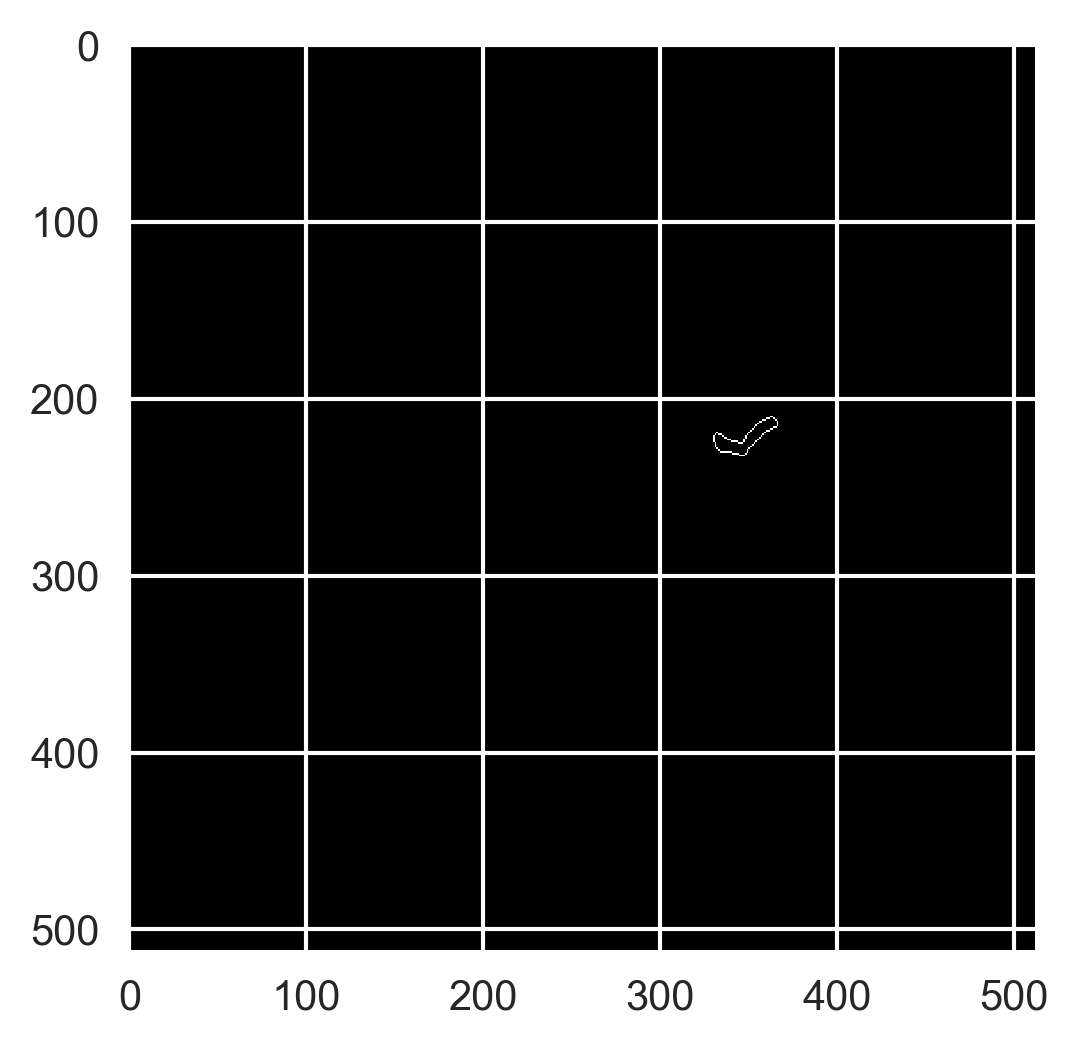

In [251]:
zeros = np.zeros_like(phase_float)
obj_id = 7
locs_x = min_conts[obj_id][:, 0].astype(int)
locs_y = min_conts[obj_id][:, 1].astype(int)
zeros[locs_x, locs_y] = 1.0
# zeros = zeros[400:650, 600:800]
skel = skimage.morphology.skeletonize(zeros)
filled = scipy.ndimage.binary_fill_holes(zeros)

# erosion = scipy.ndimage.binary_erosion(filled, iterations=5)
plt.imshow(skel, cmap=plt.cm.Greys_r)
# plt.plot(min_conts[0][:,1], min_conts[0][:,0])



In [252]:
import scipy.signal
import scipy.interpolate

In [253]:
def curvature(x, y, pos):
    """
    Computes the curvature at a given point along a two dimensional
    curve.
    
    Parameter
    ---------
    x, y: 1d-arrays 
        Data in x and y across which the curvature is computed. 
        
    """
    dx = np.diff(xnew)
    ddx = np.diff(dx)
    dy = np.diff(ynew)
    ddy = np.diff(dy)
    
    kappa = (dx[pos] * ddy[pos] - dy[pos]*ddx[pos]) /\
            (dx[pos]**2 + dy[pos]**2)**(3/2)
    return kappa
    

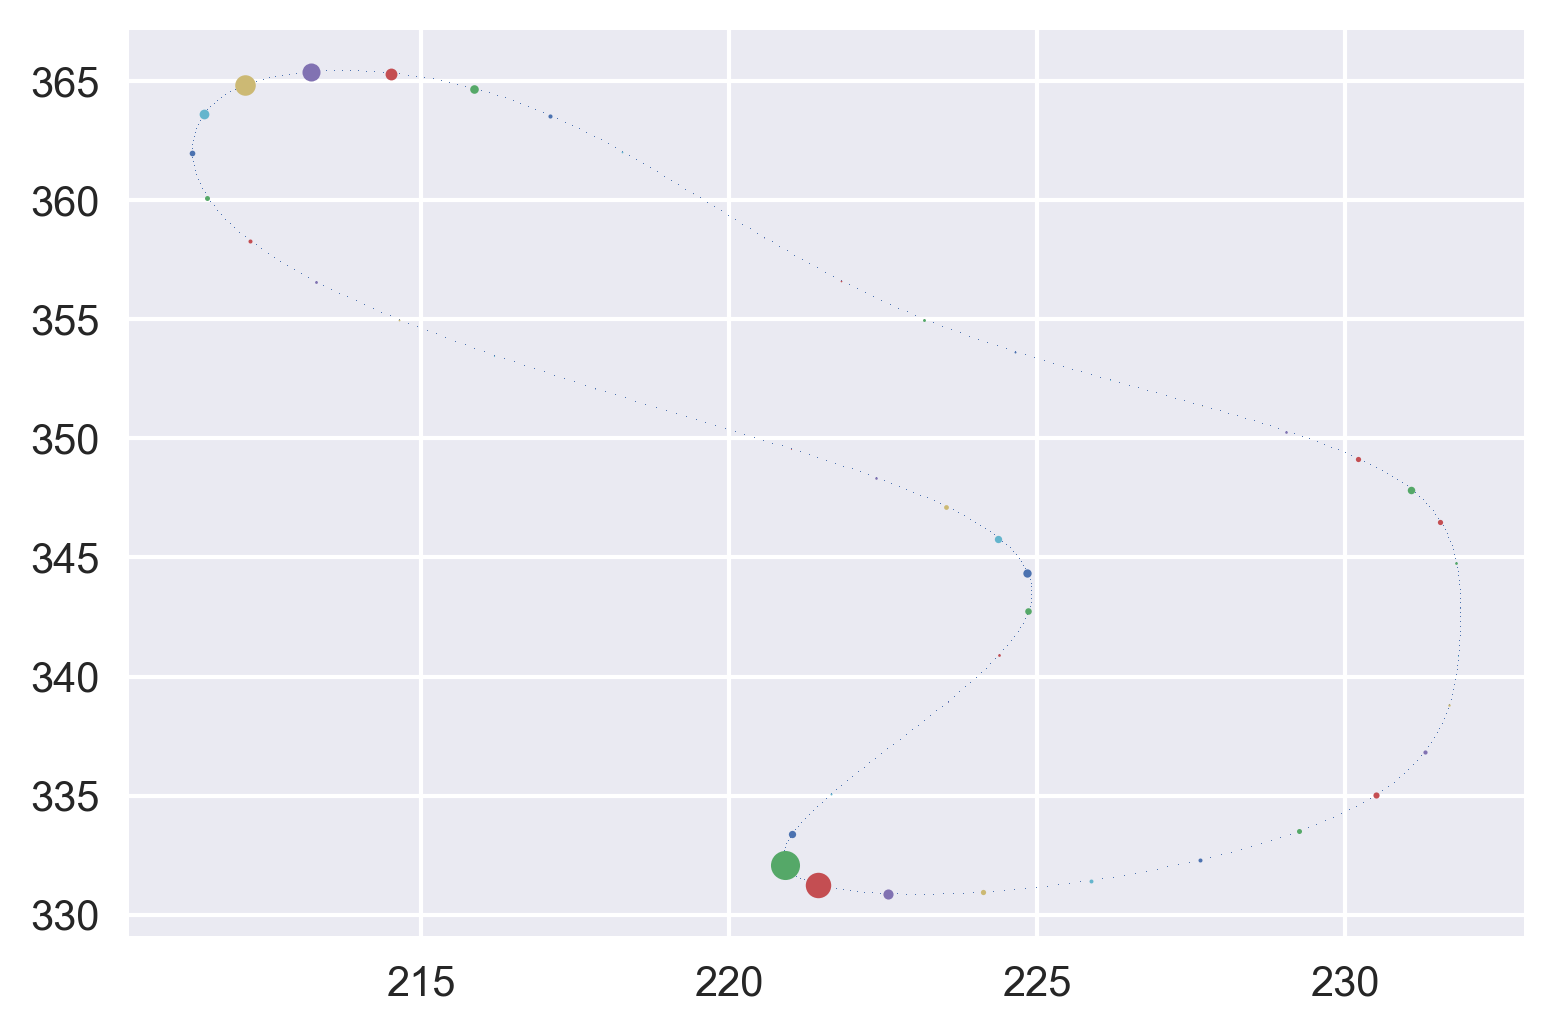

In [254]:
locs_x = min_conts[obj_id][:, 0]
locs_y = min_conts[obj_id][:, 1]

tck, u = scipy.interpolate.splprep([locs_x, locs_y], s=50, per=1)
unew = np.linspace(u.min(), u.max(), 500)
xnew, ynew = scipy.interpolate.splev(unew, tck, der=0)

plt.plot(xnew, ynew, ',')



curve = []
for i in range(0,len(xnew) - 2, 10):

    kappa = curvature(xnew, ynew, i)
    curve.append(kappa)
    plt.plot(xnew[i], ynew[i], '.', ms=20 * np.abs(kappa))
    


ValueError: x and y must have same first dimension, but have shapes (498,) and (50,)

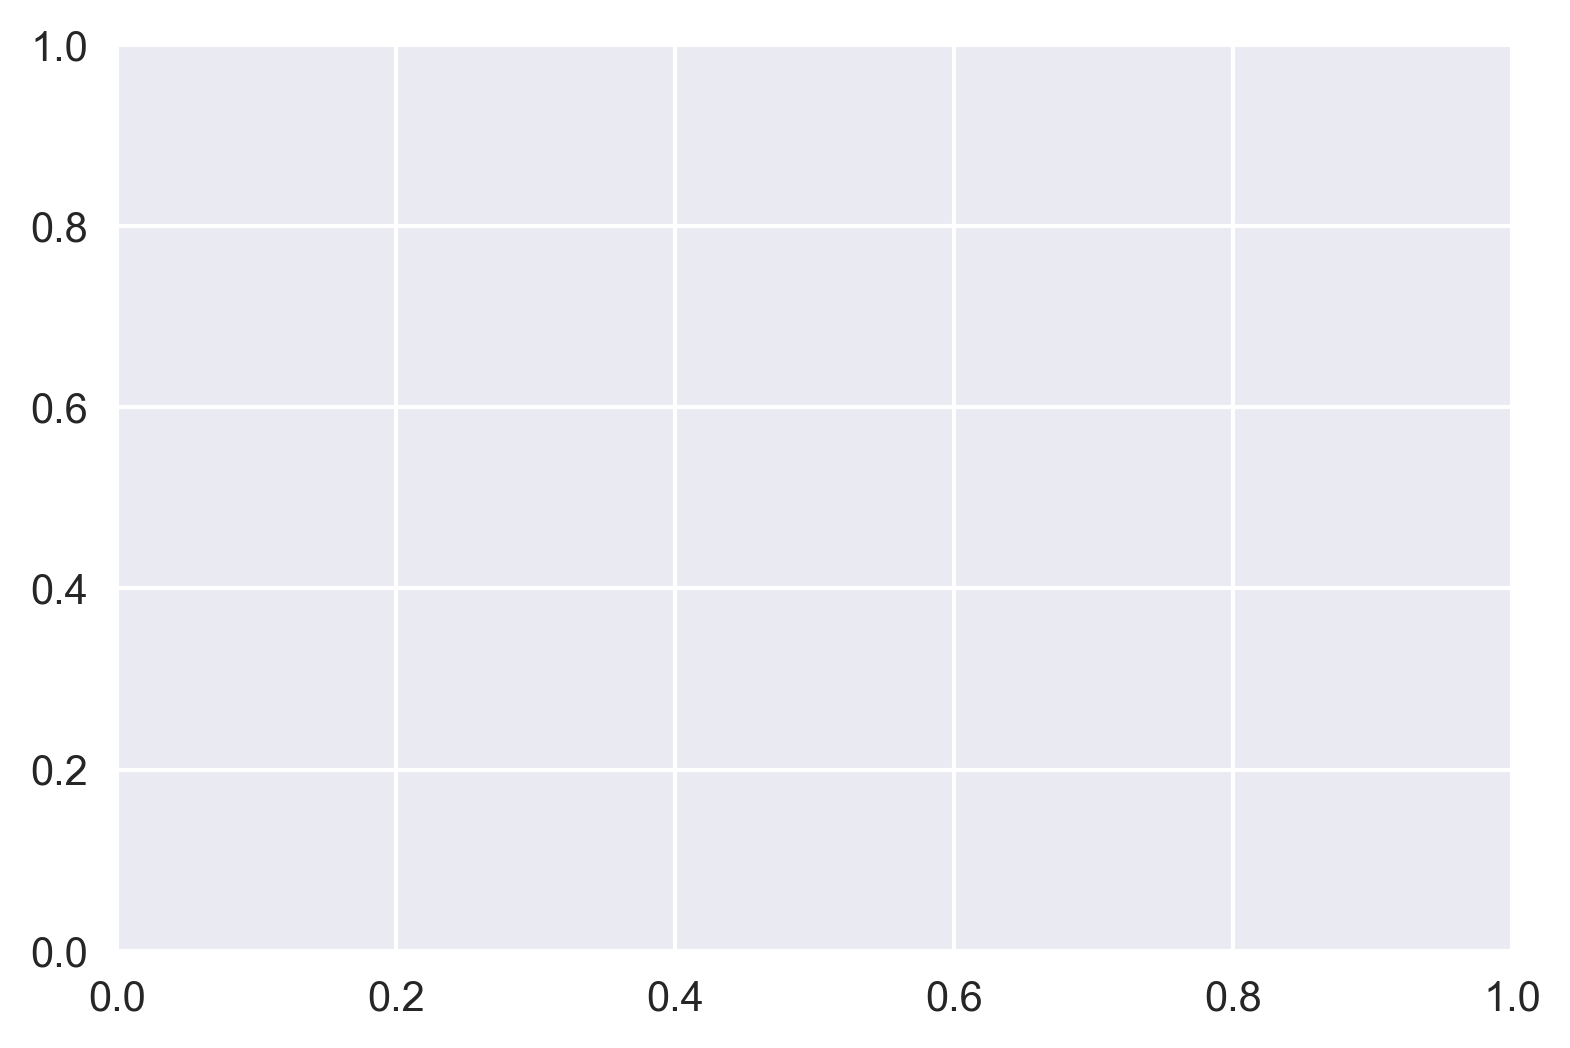

In [256]:
plt.plot(perim, curve)
plt.xlabel('position')
plt.ylabel('curvature')

In [244]:
# Get the coordinates of the local_minima
curve = np.array(curve)
mins = scipy.signal.argrelmin(np.array(curve), order=5)
min_val = curve[mins]
inds = np.where(min_val < -0.2)[0]
mins = mins[0]
coords = [(xnew[mins[i]], ynew[mins[i]]) for i in inds]

In [245]:
# Compute all pairwise distances. 
pair_dist = []
for pair1 in coords:
    _dist = []
    for pair2 in coords:
        dist = np.sqrt((pair1[0] - pair2[0])**2 + (pair1[1] - pair2[1])**2)
        if dist == 0:
            dist = 1E9
        _dist.append(dist)
    
    pair_dist.append(_dist)
    
# Make the combinations of points to connect.
cleaveage_sites = []
for i, dists in enumerate(pair_dist):
    ind = np.where(dists == np.min(dists))[0]
    print(ind)
    cleaveage_sites.append([(coords[ind][0], coords[i][0]),
                           (coords[ind][1], coords[i][1])])

[0]


/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [246]:
coords

[(239.46522111437659, 169.3495637089097)]

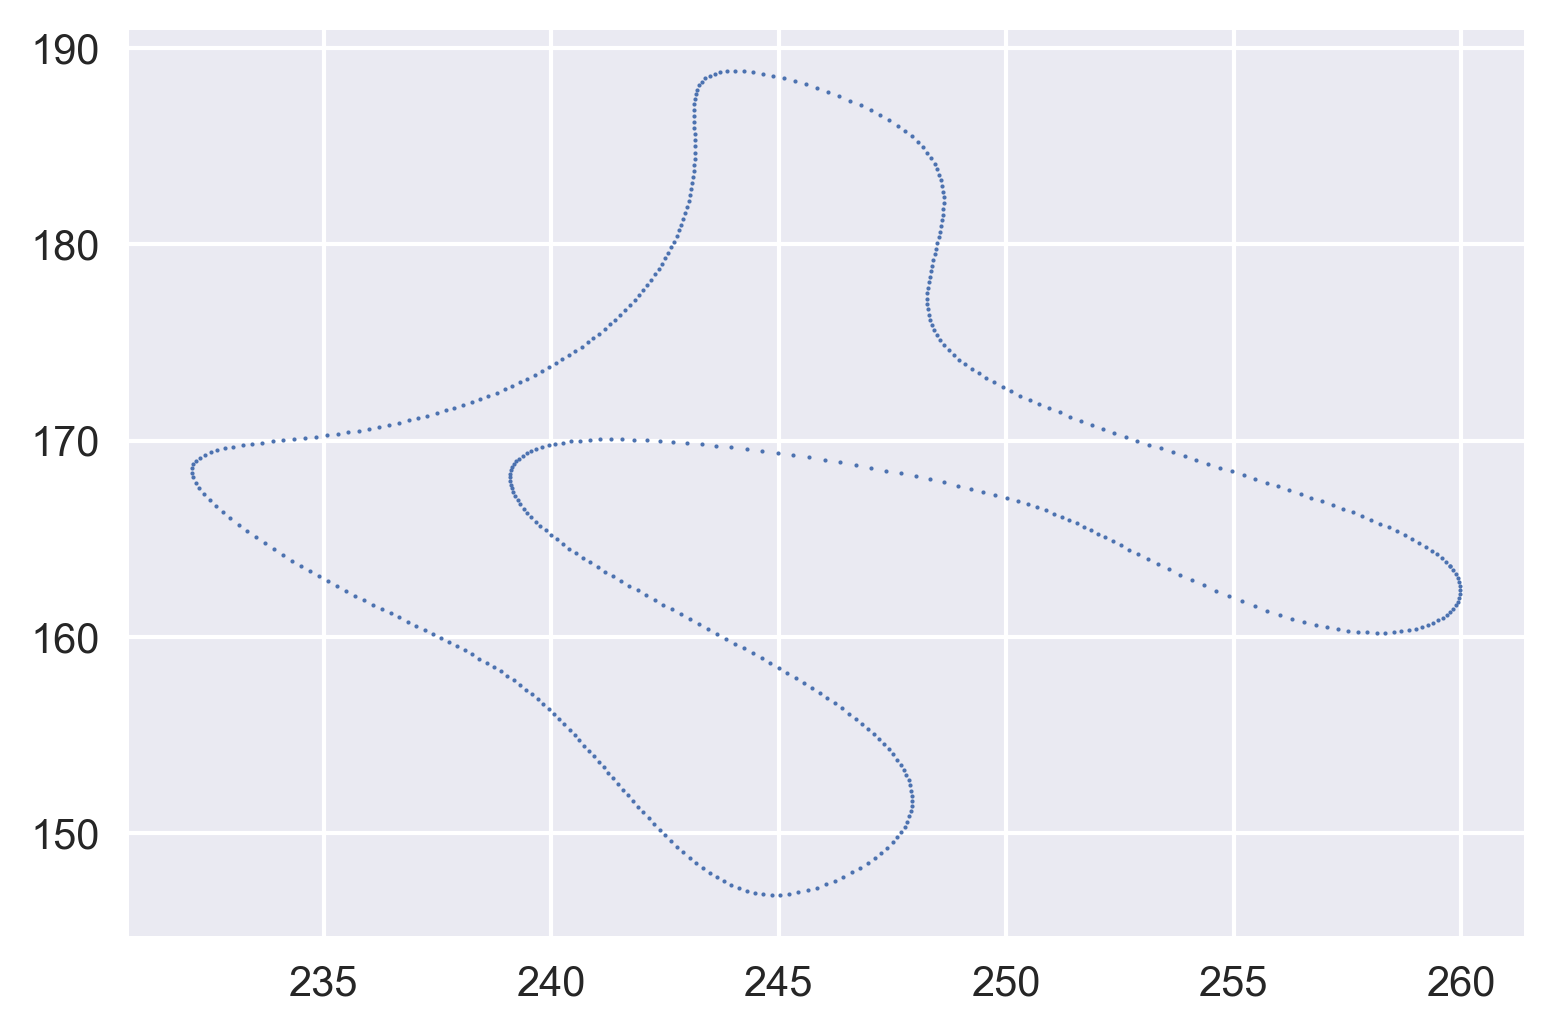

In [247]:
plt.plot(xnew, ynew, '.', ms=2)
for c in cleaveage_sites:
    plt.plot(c[0], c[1])
